# **Imports**

In [2]:
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functionsML as f
from itertools import combinations
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import LassoCV
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

from sklearn.preprocessing import MinMaxScaler

# data partition
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import importlib
importlib.reload(f)

from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')


### **Import data sets**

In [2]:
train_db = pd.read_csv("./train.csv")
test_db = pd.read_csv("./test.csv")

# **Data exploration**

Our goal here is to understand the data, and the issues that come with it

- Typos in transmission and fuel

- EngineSize with NaN

- Mileage, mpg and previousOwners with irational values

- PreviousOwners with negative values

- hasDamage seems to always be 0

- The categorical variables have a lot of unique values

- Missing values in year mileage tax mpg engineSize paintQuality% previousOwners and hasDamage

- Alarming min values in mileage tax mpg engineSize paintQuality% previousOwners

- Alarming max values in year mpg paintQuality% previousOwners

- HasDamage is always 0

- Year is float64, should be int64

- PreviousOwners is float, should be int64

# **Unique Values**

We wanted to take a better look at what kind of values each variable had, and we ended up finding:

- Typos in every categorical variable

- Different letter casing in every categorical variable

- Unrealistic negative values and irrational values in every numerical category

- There is a strong correlation between mpg's and tax's missing values

# **Distributions & Value Counts**

#### Here we aim to treat the spotted issues, treat outliers and NaN values

### **Outlier treatment**

- We can imideatly spot some issues on the graphs, including absurd values and values that don't make sense

In [ ]:
# Removed replace absurd/incorrect values with NaN for them later to be filled
train_db.loc[train_db["mileage"] < 0, "mileage"] = np.nan
train_db.loc[~train_db["tax"].between(0, 600), "tax"] = np.nan
train_db.loc[~train_db["mpg"].between(0, 150), "mpg"] = np.nan
train_db.loc[~train_db["engineSize"].between(1, 6.3), "engineSize"] = np.nan
train_db.loc[~train_db["year"].between(1990, 2020), "year"] = np.nan
test_db.loc[~test_db["previousOwners"].between(0, 6), "previousOwners"] = np.nan

#### Next we apply log(1 + x) transformation to reduce skewness and normalize distribution
#### This will help our model handle right-skewed variables better

In [60]:
train_db['price'] = np.log1p(train_db['price'])
train_db['mileage'] = np.log1p(train_db['mileage'])
train_db['mpg'] = np.log1p(train_db['mpg'])

# Apply log(1 + x) transformation to 'tax' for normalization
train_db['tax'] = np.log1p(train_db['tax'])



## **Variable Relationships**

### Our goal here is to find the best relationship between variables so we can, more accuratly, fill the missing values

First we tried to find the relation between categorical variables using Cramér's V, but we realized that the variables might be directionally related

In [21]:
cat_cols = train_db.select_dtypes(include=['object']).columns

# Compute Cramér's V between all pairs
for i, col1 in enumerate(cat_cols):
    for col2 in cat_cols[i+1:]:
        v = f.cramers_v(train_db[col1], train_db[col2])
        print(f"Cramér's V between {col1} and {col2}: {v:.3f}")

Cramér's V between Brand and model: 0.995
Cramér's V between Brand and transmission: 0.299
Cramér's V between Brand and fuelType: 0.278
Cramér's V between model and transmission: 0.363
Cramér's V between model and fuelType: 0.489
Cramér's V between transmission and fuelType: 0.199


So we ended up going with a Theil's U directional relationship, while also testing out different variable combinations

In [22]:
num_cols = train_db.select_dtypes(include='number').drop(columns=['carID', 'price'], errors='ignore').columns


# Try single and multi-column combinations up to this size
max_combo_size = 3

print("\nTheil’s U directionally for Categorical Variables:")
for target in cat_cols:
    u_scores = {}
    
    for combo_size in range(1, max_combo_size + 1):
        for combo in combinations([c for c in cat_cols if c != target], combo_size):
            # Build a joint predictor variable by concatenating category values
            joint_name = " + ".join(combo)
            joint_var = train_db[list(combo)].astype(str).agg("_".join, axis=1)
            
            # Directional association: how much knowing combo tells about target
            u = f.theils_u(train_db[target], joint_var)
            u_scores[joint_name] = u

    # Pick top combinations that best explain target
    top3 = sorted(u_scores.items(), key=lambda x: x[1], reverse=True)[:3]
    
    print(f"\nFor categorical column '{target}', best predictors:")
    for combo, u in top3:
        print(f"  U({target} | {combo}) = {u:.3f}")



Theil’s U directionally for Categorical Variables:

For categorical column 'Brand', best predictors:
  U(Brand | model + transmission + fuelType) = 0.982
  U(Brand | model + transmission) = 0.981
  U(Brand | model + fuelType) = 0.979

For categorical column 'model', best predictors:
  U(model | Brand + transmission + fuelType) = 0.562
  U(model | Brand + fuelType) = 0.538
  U(model | Brand + transmission) = 0.519

For categorical column 'transmission', best predictors:
  U(transmission | Brand + model + fuelType) = 0.326
  U(transmission | model + fuelType) = 0.316
  U(transmission | Brand + model) = 0.291

For categorical column 'fuelType', best predictors:
  U(fuelType | Brand + model + transmission) = 0.403
  U(fuelType | model + transmission) = 0.396
  U(fuelType | Brand + model) = 0.360


- We initially attempted to convert the numerical variables into categorical ones using binning so that they could be included in Theil's U calculation. However, this approach worsened the overall results, so we decided to focus solely on comparing the categorical variables.

We also explored the relationships between numerical target features and the possible combinations of numerical and categorical features. In this case, converting numerical features into bins and mixing them with categorical variables actually produced positive results.

In [23]:
for target in num_cols:
    scores = {}

    for num_paired in range(1, 3):
        # Numeric predictor combinations
        for combo in combinations([c for c in num_cols if c != target], num_paired):
            df = train_db[list(combo) + [target]].dropna()
            if df.empty:
                continue
            model = LinearRegression().fit(df[list(combo)], df[target])
            scores[combo] = model.score(df[list(combo)], df[target])

        # Categorical predictor combinations
        for cat_pair in combinations(cat_cols, num_paired):
            combined = train_db[list(cat_pair)].astype(str).agg('_'.join, axis=1)
            scores[cat_pair] = f.correlation_ratio(combined, train_db[target]) ** 2


    # Mixed numeric + categorical pairs
    for num_col in [c for c in num_cols if c != target]:
        for cat_col in cat_cols:
            df = train_db[[num_col, cat_col, target]].dropna()
            if df.empty:
                continue
            # Discretize numeric variable into bins and combine with categorical
            numeric_bins = pd.cut(df[num_col], bins=15, duplicates='drop').astype(str)
            combined = df[cat_col].astype(str) + "_" + numeric_bins
            scores[(num_col, cat_col)] = f.correlation_ratio(combined, df[target]) ** 2

    # Top 3 helpers 
    top3 = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:3]
    print(f"\nFor numerical column '{target}', top helpers (R² or η²):")
    for combo, score in top3:
        print(f" {combo} => {score:.3f}")



For numerical column 'year', top helpers (R² or η²):
 ('mileage', 'model') => 0.557
 ('mileage', 'previousOwners') => 0.509
 ('mileage', 'engineSize') => 0.509

For numerical column 'mileage', top helpers (R² or η²):
 ('year', 'model') => 0.588
 ('year', 'fuelType') => 0.559
 ('year', 'Brand') => 0.535

For numerical column 'tax', top helpers (R² or η²):
 ('year', 'model') => 0.524
 ('mpg', 'model') => 0.494
 ('mpg', 'Brand') => 0.370

For numerical column 'mpg', top helpers (R² or η²):
 ('model', 'fuelType') => 0.623
 ('tax', 'model') => 0.476
 ('engineSize', 'fuelType') => 0.473

For numerical column 'engineSize', top helpers (R² or η²):
 ('mpg', 'model') => 0.803
 ('tax', 'model') => 0.737
 ('model', 'fuelType') => 0.698


KeyboardInterrupt: 

## **Filling in missing values**

In [ ]:
# Safely convert previousOwners and year to nullable integers
train_db["previousOwners"] = pd.to_numeric(train_db["previousOwners"], errors='coerce').round().astype("Int64")
train_db["year"] = pd.to_numeric(train_db["year"], errors='coerce').round().astype("Int64")

# Handle Brand for i3
idx_to_drop = train_db[(train_db['model'] == 'i3') & (train_db['Brand'].isna())].index
train_db = train_db.drop(idx_to_drop)

# Fill categorical columns
train_db = f.fill_NaN_with_categorical(train_db, "Brand", ["model","transmission","fuelType"])
train_db = f.fill_NaN_with_categorical(train_db, "Brand", ["model","transmission"]) # second best filling combination so we can best assure it gets filled 
train_db = f.fill_NaN_with_categorical(train_db, "model", ["Brand","transmission","fuelType"])
train_db = f.fill_NaN_with_categorical(train_db, "model", ["Brand","transmission"]) # second best filling combination so we can best assure it gets filled 
train_db = f.fill_NaN_with_categorical(train_db, "mpg", ["model","fuelType"])
train_db["transmission"] = train_db["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
train_db["fuelType"] = train_db["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

# Fill numeric columns with mixed helper approach
train_db = f.fill_NaN_with_mixed(train_db, "year", "model", "mileage")
train_db = f.fill_NaN_with_mixed(train_db, "mileage", "model", "year")
train_db = f.fill_NaN_with_mixed(train_db, "tax", "model", "year")
train_db = f.fill_NaN_with_mixed(train_db, "engineSize", "model", "tax")

# Fill numeric columns with median
train_db["previousOwners"] = train_db["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64")

# Drop any remaining NaNs
train_db = train_db.dropna()


- Now no variable has missing values

# **Feature Selection**

- year and mileage have a strong relationship
- and so does tax and pmg
- both paintQuality% and previousOwners seem to have little correlation with every variable

We need to encode categorical variables into numericals, and we decided to encode Brand transmission and fuelType with one-hot encoding, and we also created a Brand_model_encoded where, using kfold traget encode, we can achieve a numerical model without having to worry about different brands having models with the same name

In [65]:
one_hot = pd.get_dummies(train_db["Brand"], drop_first=True).astype(int)

train_db = pd.concat([train_db, one_hot], axis=1)

train_db['transmission'] = train_db['transmission'].replace('other', 'unknown')

one_hot2 = pd.get_dummies(train_db["transmission"], drop_first=True).astype(int)

train_db = pd.concat([train_db, one_hot2], axis=1)

train_db["fuelType"] = train_db["fuelType"].replace('other', 'electric')

one_hot3 = pd.get_dummies(train_db["fuelType"], drop_first=True).astype(int)

train_db = pd.concat([train_db, one_hot3], axis=1)

train_db = f.kfold_target_encode(train_db, cat_cols=['Brand','model'], target_col='price', n_splits=5)

We split the dataframe into two groups, one to train the model, and the other to validate it

In [66]:
X = train_db.drop(columns=["price","carID"])
y = train_db["price"]
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.3, 
                                                  random_state = 0, 
                                                  shuffle = True)

X has the numeric variables extracted and scaled

In [67]:
X_train_cat = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)

X_train_num = X_train.select_dtypes(include=np.number).set_index(X_train.index)

# repeat for val

X_val_cat = X_val.select_dtypes(exclude=np.number).set_index(X_val.index)

X_val_num = X_val.select_dtypes(include=np.number).set_index(X_val.index)

In [68]:
scaler = MinMaxScaler()

#fit to training data
scaler.fit(X_train_num)

#transform the data
X_train_num_scaled = scaler.transform(X_train_num) # this will return an array

# Convert the array to a pandas dataframe
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train_num.columns).set_index(X_train.index)

X_val_num_scaled = scaler.transform(X_val_num)
X_val_num_scaled = pd.DataFrame(X_val_num_scaled, columns = X_val_num.columns).set_index(X_val.index)


#show results
X_train_num_scaled

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,bmw,ford,hyundai,...,skoda,toyota,vw,manual,semi-auto,unknown,electric,hybrid,petrol,Brand_model_encoded
60160,0.916667,0.883816,0.788292,0.785324,0.096154,0.291581,0.500,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.459319
22094,0.875000,0.814598,0.798367,0.718810,0.115385,0.989733,0.500,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.405266
22972,0.875000,0.816178,0.783001,0.800108,0.192308,0.702259,0.250,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.597505
2763,0.791667,0.786634,0.000000,0.810526,0.000000,0.784394,0.250,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.451245
65695,0.833333,0.759395,0.858452,0.711955,0.384615,0.671458,0.750,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.719603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21255,0.833333,0.749421,0.000000,0.737770,0.115385,0.353183,0.625,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.451397
45925,0.708333,0.878278,0.478341,0.785324,0.000000,0.312115,0.625,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.508462
42644,0.916667,0.563101,0.783001,0.715671,0.076923,0.938398,0.625,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.400069
43598,0.875000,0.689388,0.539532,0.781776,0.057692,0.887064,0.750,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.461324


Checking the categorical variables correlation with the target

In [69]:
for var in X_train_cat:
    f.TestCorrelationRatio(X_train_cat[var],y_train, var)

Brand is IMPORTANT for prediction (η = 0.565)
model is IMPORTANT for prediction (η = 0.750)
transmission is IMPORTANT for prediction (η = 0.567)
fuelType is IMPORTANT for prediction (η = 0.251)


Calculated the optimal number of features for a Linear Regression

In [70]:
#no of features
nof_list=np.arange(1,len(X_train_num_scaled.columns)+1)            
high_score=0
#Variable to store the optimum features
nof=0           
train_score_list =[]
val_score_list = []

for n in range(len(nof_list)):
    model = LinearRegression()
    
    rfe = RFE(estimator = model,n_features_to_select = nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_num_scaled,y_train)
    X_val_rfe = rfe.transform(X_val_num_scaled)
    model.fit(X_train_rfe,y_train)
    
    #storing results on training data
    train_score = model.score(X_train_rfe,y_train)
    train_score_list.append(train_score)
    
    #storing results on validation data
    val_score = model.score(X_val_rfe,y_val)
    val_score_list.append(val_score)
    
    #check best score
    if(val_score >= high_score):
        high_score = val_score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 22
Score with 22 features: 0.895541


In [71]:
model = LinearRegression()

rfe = RFE(estimator = model, n_features_to_select = 19)

train_db_rfe = rfe.fit_transform(X = X_train_num_scaled, y = y_train)

rfe.support_

array([ True,  True,  True,  True,  True, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True])

In [72]:
X_train_num_scaled.columns

Index(['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%',
       'previousOwners', 'bmw', 'ford', 'hyundai', 'mercedes', 'opel', 'skoda',
       'toyota', 'vw', 'manual', 'semi-auto', 'unknown', 'electric', 'hybrid',
       'petrol', 'Brand_model_encoded'],
      dtype='object')

In [73]:
rfe.ranking_

array([1, 1, 1, 1, 1, 3, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1])

In [74]:
selected_features = pd.Series(rfe.support_, index = X_train_num_scaled.columns)
selected_features

year                    True
mileage                 True
tax                     True
mpg                     True
engineSize              True
paintQuality%          False
previousOwners         False
bmw                     True
ford                    True
hyundai                 True
mercedes                True
opel                    True
skoda                   True
toyota                  True
vw                      True
manual                  True
semi-auto              False
unknown                 True
electric                True
hybrid                  True
petrol                  True
Brand_model_encoded     True
dtype: bool

Check the feature importance with the LassoCV

In [75]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

reg = LassoCV()


reg.fit(X_train_num_scaled, y_train)

coef = pd.Series(reg.coef_, index = X_train_num_scaled.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


Lasso picked 20 variables and eliminated the other 2 variables


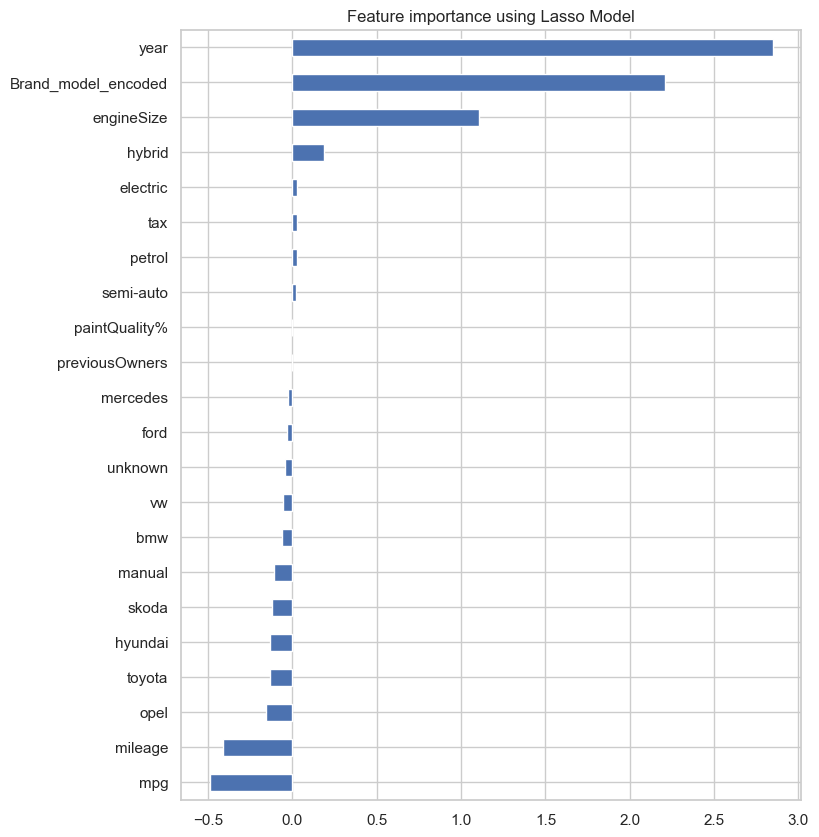

In [76]:
plot_importance(coef,'Lasso')

<hr>

### Numerical Data

| Predictor | Pearson | RFE LR| Lasso | What to do? (One possible way to "solve") | 
| --- | --- | --- | --- |---|
| year | Keep? | Keep | Keep | Include in the model |
| engineSize | Keep | Keep |Keep| Include in the model |
| tax | Keep?| Discard? | Discard | Try with and without |
| previousOwners | Keep? | Discard | Discard | Discard |
| mpg | Keep? | Keep | Keep? | Try with and without |
| mileage | Keep? | Keep | Keep | Keep |

<hr>


### Categorical Data

| Predictor | Correlation Ratio | 
| --- | --- | 
| Brand | Keep |  
|  model | Keep | 
| transmission | Keep |
| fuelType| Keep? |


<hr>



After testing out different combinations, we came to the conclusion that dropping previousOwners and paintQuality% had the best return

In [ ]:
X_train_num_scaled = X_train_num_scaled.drop(columns=['previousOwners'])

X_val_num_scaled = X_val_num_scaled.drop(columns=['previousOwners'])

perguntar ao professor mesmo se knn nao se pode usar as variaveis categoricas emsmo depois de transformadas em numericas, porque da melhor resultado no entanto o chat gpt diz que nao se deva variaveis categoricas mesmo depois ... antes estava r2 0.93 e depois 0.85

Tipo de dado         	Métrica recomendada
Numérico contínuo,escalado	                  euclidean ou minkowski (p=2)
Numérico com outliers	                      manhattan ou chebyshev
Dados normalizados entre 0 e 1	                euclidean ou cosine
Dados correlacionados ou com escalas diferentes	                  mahalanobis
Alta dimensionalidade, direção importa (ex: embeddings)	            cosine

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV # Importação alterada
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from scipy.stats import randint # Útil para definir intervalos de números inteiros aleatórios


X_train_num_scaled_import = X_train_num_scaled[['year', 'mileage', 'tax', 'mpg', 'engineSize']]
X_val_num_scaled_import   = X_val_num_scaled[['year', 'mileage', 'tax', 'mpg', 'engineSize']]


# 1. Definir o modelo
knn = KNeighborsRegressor(n_jobs=-1)

# 2. Definir a distribuição dos parâmetros
# No RandomizedSearch, para valores numéricos, usamos distribuições (como randint)
# ou listas. Ele vai "sortear" valores daqui.
param_dist = {
    'n_neighbors': randint(1, 31),  # Sorteia valores inteiros entre 1 e 30
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

# 3. Configurar a busca (Randomized Search)
# n_iter=20: Define que vamos testar apenas 20 combinações aleatórias (mais rápido que o Grid)
random_search = RandomizedSearchCV(
    estimator=knn, 
    param_distributions=param_dist, 
    n_iter=20, # Número de iterações (combinações aleatórias) a testar
    cv=5, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    random_state=42 # Garante que os sorteios sejam reproduzíveis
)

# 4. Treinar
print("Procurando os melhores hiperparâmetros (Random Search)...")
random_search.fit(X_train_num_scaled_import, y_train)

# 5. Resultados
best_model = random_search.best_estimator_
print(f"Melhores parâmetros encontrados: {random_search.best_params_}")

# 6. Avaliação Final na Validação
pred = best_model.predict(X_val_num_scaled_import)
rmse = np.sqrt(mean_squared_error(y_val, pred))

print("-" * 30)
print(f"R²: {r2_score(y_val, pred):.3f}")
print(f"MAE: {mean_absolute_error(y_val, pred):.2f}")
print(f"RMSE: {rmse:.2f}")

Procurando os melhores hiperparâmetros (Random Search)...
Melhores parâmetros encontrados: {'metric': 'manhattan', 'n_neighbors': 29, 'weights': 'distance'}
------------------------------
R²: 0.865
MAE: 0.14
RMSE: 0.20


In [ ]:
# --- 1. Limpeza e Pré-processamento Inicial ---
# (Idêntico ao pipeline anterior, garantindo consistência)

# Carregar dataset de teste
test_db = pd.read_csv("test.csv")
test_db = test_db.drop(columns="hasDamage", errors='ignore')

# Lowercase text columns
text_cols = test_db.select_dtypes(include=["object"]).columns
test_db[text_cols] = test_db[text_cols].apply(lambda x: x.str.lower() if x.dtype=="object" else x)

# Corrigir gralhas
for col in test_db.select_dtypes(include="object").columns:
    test_db = f.fix_typos(col, test_db)

# Tratamento de valores negativos/irracionais
test_db.loc[test_db["mileage"] < 0, "mileage"] = np.nan
test_db.loc[~test_db["tax"].between(0, 400), "tax"] = np.nan
test_db.loc[~test_db["mpg"].between(0, 150), "mpg"] = np.nan
test_db.loc[~test_db["engineSize"].between(1, 6), "engineSize"] = np.nan
test_db.loc[~test_db["year"].between(1990, 2020), "year"] = np.nan
test_db.loc[(test_db['previousOwners'] < 0) | (test_db['previousOwners'] % 1 != 0),'previousOwners'] = np.nan

# Round floats
for col in test_db.select_dtypes(include="float64").columns:
    test_db[col] = test_db[col].round(1)

# Converter para inteiros nullable
test_db["previousOwners"] = pd.to_numeric(test_db["previousOwners"], errors='coerce').round().astype("Int64")
test_db["year"] = pd.to_numeric(test_db["year"], errors='coerce').round().astype("Int64")

# --- 2. Transformações Numéricas (Essencial para KNN - Distâncias) ---

test_db['mileage'] = np.log1p(test_db['mileage'])
test_db['mpg'] = np.log1p(test_db['mpg'])

# Usar os limites do treino (tax_lower, tax_upper) se existirem
if 'tax_lower' in locals():
    test_db['tax'] = test_db['tax'].clip(tax_lower, tax_upper)
test_db['tax'] = np.log1p(test_db['tax'])

if 'engineSize_lower' in locals():
    test_db['engineSize'] = test_db['engineSize'].clip(engineSize_lower, engineSize_upper)

# --- 3. Imputação de Valores em Falta ---

test_db = f.fill_NaN_with_categorical(test_db, "Brand", ["model","transmission","fuelType"])
test_db = f.fill_NaN_with_categorical(test_db, "Brand", ["model","transmission"])
test_db = f.fill_NaN_with_categorical(test_db, "model", ["Brand","transmission","fuelType"])
test_db = f.fill_NaN_with_categorical(test_db, "model", ["Brand","transmission"])
test_db = f.fill_NaN_with_categorical(test_db, "mpg", ["model","fuelType"])
test_db["transmission"] = test_db["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
test_db["fuelType"] = test_db["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

test_db = f.fill_NaN_with_mixed(test_db, "year", "model", "mileage")
test_db = f.fill_NaN_with_mixed(test_db, "mileage", "model", "year")
test_db = f.fill_NaN_with_mixed(test_db, "tax", "model", "year")
test_db = f.fill_NaN_with_mixed(test_db, "engineSize", "model", "tax")

test_db["previousOwners"] = test_db["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64")

# Preencher residuais com médias de grupo ou globais
numeric_cols = test_db.select_dtypes(include=["number"]).columns.drop("carID", errors='ignore')
for col in numeric_cols:
    test_db[col] = test_db[col].astype(float)
    category_means = test_db.groupby("model")[col].transform('median')
    test_db[col] = test_db[col].fillna(category_means)
    global_mean = test_db[col].median()
    test_db[col] = test_db[col].fillna(global_mean)
    if "Int64" in str(test_db[col].dtype):
        test_db[col] = test_db[col].round().astype("Int64")

# --- 4. Encoding e Escalonamento ---

# One-hot encode (necessário para manter consistência das colunas, mesmo que não usemos no KNN final)
brand_dummies = pd.get_dummies(test_db["Brand"], drop_first=True).astype(int)
test_db = pd.concat([test_db, brand_dummies], axis=1)

test_db['transmission'] = test_db['transmission'].replace('other', 'unknown')
transmission_dummies = pd.get_dummies(test_db["transmission"], drop_first=True).astype(int)
test_db = pd.concat([test_db, transmission_dummies], axis=1)

test_db["fuelType"] = test_db["fuelType"].replace('other', 'electric')
fuel_dummies = pd.get_dummies(test_db["fuelType"], drop_first=True).astype(int)
test_db = pd.concat([test_db, fuel_dummies], axis=1)

# Selecionar colunas numéricas
X_test_num = test_db.select_dtypes(include=np.number).set_index(test_db.index)
X_test_num = X_test_num.drop(columns=["carID", "price"], errors='ignore')

# Alinhar colunas com o treino (X_train_num deve estar em memória)
X_test_num = X_test_num.reindex(columns=X_train_num.columns, fill_value=0)

# Escalonamento (Obrigatório para KNN)
X_test_num_scaled = scaler.transform(X_test_num)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns, index=X_test_num.index)

# --- 5. Seleção de Features Específica do KNN ---
# No notebook (Célula 23/24), o KNN foi treinado apenas com estas 5 colunas.
# Temos de filtrar o dataset de teste para ter as mesmas colunas.

knn_features = ['year', 'mileage', 'tax', 'mpg', 'engineSize']
X_test_knn = X_test_num_scaled[knn_features]

# --- 6. Previsão com KNN ---

if 'best_model' in locals():
    print(f"A usar o melhor modelo KNN do GridSearch com parâmetros: {best_model.get_params()}")
    model_to_use = best_model
elif 'knn_model' in locals():
    print("A usar o modelo KNN base (knn_model)...")
    model_to_use = knn_model
else:
    raise ValueError("Nenhum modelo KNN treinado encontrado (best_model ou knn_model). Execute a célula de treino do KNN primeiro.")

# Prever
y_test_pred = model_to_use.predict(X_test_knn)

# Inverter Log (np.log1p -> np.expm1)
test_db['price'] = np.expm1(y_test_pred)

# --- 7. Submissão ---

submission = test_db[['carID', 'price']].copy()
submission.to_csv("submission_knn.csv", index=False)
print("Ficheiro 'submission_knn.csv' criado com sucesso.")

ValueError: Nenhum modelo KNN treinado encontrado (best_model ou knn_model). Execute a célula de treino do KNN primeiro.

A treinar a Rede Neuronal...
Epoch 1/100
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 3.7409 - mae: 1.2495 - val_loss: 0.0522 - val_mae: 0.1695
Epoch 2/100
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.9325 - mae: 0.7676 - val_loss: 0.0797 - val_mae: 0.2334
Epoch 3/100
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4715 - mae: 0.5403 - val_loss: 0.0602 - val_mae: 0.1840
Epoch 4/100
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1922 - mae: 0.3403 - val_loss: 0.0395 - val_mae: 0.1464
Epoch 5/100
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0702 - mae: 0.2001 - val_loss: 0.0388 - val_mae: 0.1472
Epoch 6/100
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0462 - mae: 0.1601 - val_loss: 0.0284 - val_mae: 0.1235
Epoch 7/100
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0398 - mae: 0.1480 - val_loss: 0.0282 - val_mae: 0.1226
Epoch 8/100
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0363 - mae: 0.1403 - val_loss: 0.0268 - val_mae: 0.1191
Epo

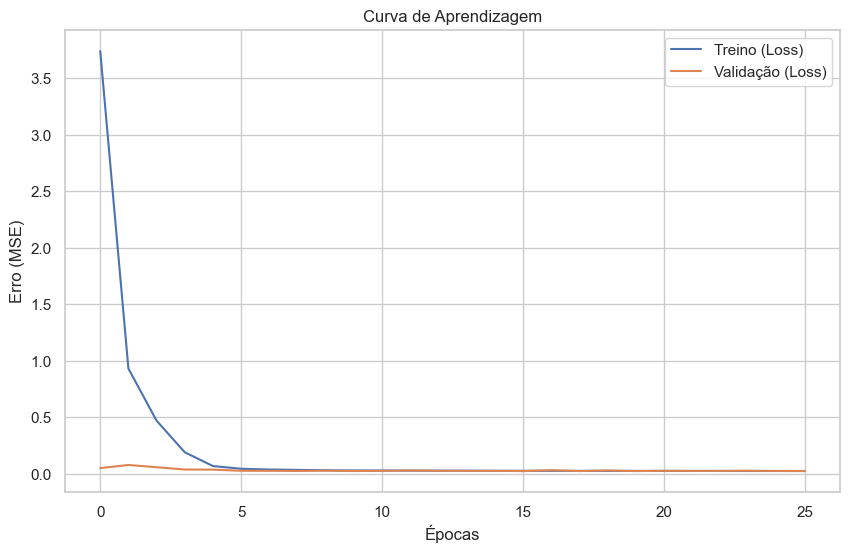

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# 1. Definir a Arquitetura da Rede
# Input shape é o número de colunas (features) que temos
input_shape = [X_train_num_scaled.shape[1]]

model = keras.Sequential([
    # Primeira camada oculta com 64 neurónios e ativação ReLU
    layers.Dense(64, activation='relu', input_shape=input_shape),
    # Dropout ajuda a prevenir overfitting desligando 20% dos neurónios aleatoriamente
    layers.Dropout(0.2),
    
    # Segunda camada oculta
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    
    # Terceira camada oculta (opcional, para mais complexidade)
    layers.Dense(16, activation='relu'),
    
    # Camada de Saída: 1 único neurónio para prever o preço (valor contínuo)
    layers.Dense(1)
])

# 2. Compilar o Modelo
# 'adam' é um otimizador excelente e versátil
# 'mae' (Mean Absolute Error) é uma boa métrica de perda para preços
model.compile(
    optimizer='adam',
    loss='mean_squared_error', # Usamos MSE para guiar o treino (penaliza grandes erros)
    metrics=['mae']
)

# 3. Configurar Paragem Antecipada (Early Stopping)
# Se o modelo parar de melhorar na validação, paramos o treino para não decorar os dados
early_stopping = EarlyStopping(
    min_delta=0.001, # Mínima melhoria considerada
    patience=10,     # Quantas épocas esperar sem melhoria antes de parar
    restore_best_weights=True
)

# 4. Treinar a Rede
print("A treinar a Rede Neuronal...")
history = model.fit(
    X_train_num_scaled, y_train,
    validation_data=(X_val_num_scaled, y_val),
    batch_size=32, # Quantos carros analisa de cada vez antes de atualizar pesos
    epochs=100,    # Máximo de passagens pelos dados
    callbacks=[early_stopping],
    verbose=1 # Mostra a barra de progresso
)

# 5. Avaliar o Desempenho
y_pred_nn = model.predict(X_val_num_scaled)

print("\n--- Resultados da Rede Neuronal ---")
print(f"R²: {r2_score(y_val, y_pred_nn):.3f}")
print(f"MAE: {mean_absolute_error(y_val, y_pred_nn):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_pred_nn)):.2f}")

# 6. Gráfico de Aprendizagem (Loss Curve)
# Isto mostra se o modelo estava a aprender bem ou a decorar (overfitting)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Treino (Loss)')
plt.plot(history.history['val_loss'], label='Validação (Loss)')
plt.title('Curva de Aprendizagem')
plt.xlabel('Épocas')
plt.ylabel('Erro (MSE)')
plt.legend()
plt.grid(True)
plt.show()

A treinar o MLPRegressor...
Iteration 1, loss = 4.79436540
Validation score: 0.391093
Iteration 2, loss = 0.03958401
Validation score: 0.846063
Iteration 3, loss = 0.02065649
Validation score: 0.865710
Iteration 4, loss = 0.01896261
Validation score: 0.869871
Iteration 5, loss = 0.01773485
Validation score: 0.882251
Iteration 6, loss = 0.01664553
Validation score: 0.888977
Iteration 7, loss = 0.01583338
Validation score: 0.892223
Iteration 8, loss = 0.01537948
Validation score: 0.896965
Iteration 9, loss = 0.01483318
Validation score: 0.898773
Iteration 10, loss = 0.01441154
Validation score: 0.901316
Iteration 11, loss = 0.01396108
Validation score: 0.900293
Iteration 12, loss = 0.01365883
Validation score: 0.905740
Iteration 13, loss = 0.01348084
Validation score: 0.900651
Iteration 14, loss = 0.01321872
Validation score: 0.905495
Iteration 15, loss = 0.01306151
Validation score: 0.910797
Iteration 16, loss = 0.01265766
Validation score: 0.909899
Iteration 17, loss = 0.01255323
Valid

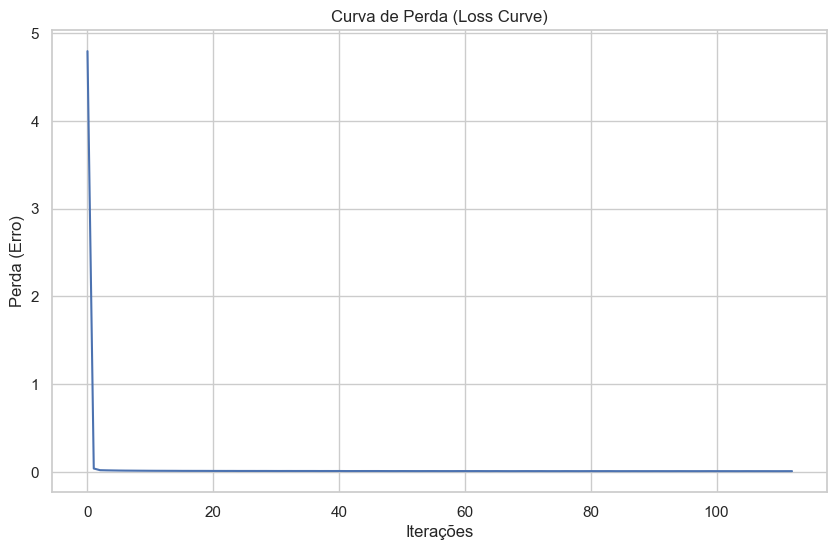


--- Resultados do MLPRegressor ---
R²: 0.932
MAE: 0.10
RMSE: 0.14


In [26]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Definir a Rede Neuronal (MLPRegressor)
# De acordo com a aula, definimos as camadas ocultas. 
# Vamos tentar uma configuração "Média/Forte": 2 camadas com 100 e 50 neurónios.
# 'max_iter' define quantas vezes a rede vê os dados.
# 'early_stopping' pára o treino se não houver melhorias (evita overfitting).
mlp_model = MLPRegressor(
    hidden_layer_sizes=(100, 50), 
    activation='relu', 
    solver='adam', 
    max_iter=500, 
    early_stopping=True, 
    random_state=42,
    verbose=True # Para ver o progresso como no notebook da aula
)

# 2. Treinar o Modelo
print("A treinar o MLPRegressor...")
mlp_model.fit(X_train_num_scaled, y_train)

# 3. Visualizar a Curva de Aprendizagem (Igual à aula)
# Isto mostra como o erro diminuiu ao longo das iterações
plt.figure(figsize=(10, 6))
losses = mlp_model.loss_curve_
iterations = range(mlp_model.n_iter_)
sns.lineplot(x=iterations, y=losses)
plt.title('Curva de Perda (Loss Curve)')
plt.xlabel('Iterações')
plt.ylabel('Perda (Erro)')
plt.grid(True)
plt.show()

# 4. Avaliação
y_pred_mlp = mlp_model.predict(X_val_num_scaled)

print("\n--- Resultados do MLPRegressor ---")
print(f"R²: {r2_score(y_val, y_pred_mlp):.3f}")
print(f"MAE: {mean_absolute_error(y_val, y_pred_mlp):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_pred_mlp)):.2f}")

eles disseram que nao posso ir ja com os dados tratados nao posso fazer holdout ( que aquilo que nos fazemos (separamos os dados em validacao e treino)) e depois cross validation que é o que esta no random search , posso faZER holdout mas tenho depois juntar e indicar 0 num grupo e -1 noutro e depois introduzir esse dataset no random search ou netao meter os dados cru e depois fazer pipeline ,,, treshold variaveis que tem menos do que aquela variancia vao embora porque os que nao tem variancia nao interessam,,,,,   

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import uniform, randint # Necessário para distribuições aleatórias

# 1. Definir a Grelha para Random Search
# No Random Search, podemos usar distribuições (ex: uniform) em vez de listas fixas
param_dist = {
    # Arquitetura: Testamos desde redes simples até muito profundas/largas
    'hidden_layer_sizes': [
        (50,), (100,), (100, 50), (200, 100), 
        (100, 50, 25), (200, 100, 50)  ###incluir sempre os defaults
    ],
    
    # Ativação: A Tanh por vezes lida melhor com regressão do que a ReLU
    'activation': ['relu', 'tanh', 'logistic'],
    
    # Solver: O SGD é clássico, Adam é moderno, LBFGS é bom para dados pequenos
    'solver': ['adam', 'sgd', 'lbfgs'],
    
    # Alpha (Regularização): Usamos uma distribuição contínua para testar valores muito finos
    'alpha': uniform(0.0001, 0.05), # Testa qualquer valor entre 0.0001 e 0.05
    
    'batch_size': [32, 64, 'auto'],
    # Learning Rate: Importante para o SGD
    'learning_rate': ['constant', 'adaptive', 'invscaling'],
    
    
    # Early Stopping: Ativar para evitar overfitting
    'early_stopping': [True],
    #como tenho early stopping 
    # Validation Fraction: Quanto dos dados de treino usar para parar cedo (se early_stopping=True)
    'validation_fraction': [0.1, 0.2]
}

# 2. Configurar o Modelo Base
mlp = MLPRegressor(max_iter=1000, random_state=42) # 2000 iterações para dar tempo ao SGD

# 3. Configurar a Busca Aleatória (Random Search)
# n_iter=50 significa que vamos testar 50 combinações aleatórias diferentes
random_search = RandomizedSearchCV(
    mlp, 
    param_distributions=param_dist, 
    n_iter=50,      # Aumente para 100 se tiver tempo (melhor resultado)
    cv=3,           # Validação cruzada de 3 folds
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,      # Usa todos os cores do CPU
    verbose=1,
    random_state=42
)

print("A executar Randomized Search (a testar 50 combinações complexas)...")
random_search.fit(X_train_num_scaled, y_train)

# 4. Melhores Resultados
best_nn = random_search.best_estimator_
print(f"\nMelhores Parâmetros Encontrados:\n{random_search.best_params_}")

# 5. Gráfico da Curva de Aprendizagem (Loss Curve)
# Nota: LBFGS não suporta loss_curve_ nem early_stopping da mesma forma
if best_nn.solver != 'lbfgs':
    plt.figure(figsize=(10, 6))
    plt.plot(best_nn.loss_curve_, label='Training Loss')
    # Se early_stopping foi usado efetivamente, podemos ter validation scores
    if hasattr(best_nn, 'validation_scores_') and best_nn.validation_scores_ is not None:
        plt.plot(best_nn.validation_scores_, label='Validation Score (Accuracy/R2 proxy)')
        
    plt.title(f'Evolução do Treino - Solver: {best_nn.solver} | Ativação: {best_nn.activation}')
    plt.xlabel('Iterações')
    plt.ylabel('Loss / Score')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"A rede parou após {best_nn.n_iter_} iterações.")
else:
    print(f"O solver vencedor foi '{best_nn.solver}' (Otimizador analítico - sem gráfico de evolução iterativa).")

# 6. Avaliação Final nos Dados de Validação
y_pred_nn = best_nn.predict(X_val_num_scaled)
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

print("\n--- Performance Final (Random Search) ---")
print(f"R²: {r2_score(y_val, y_pred_nn):.3f}")
print(f"MAE: {mean_absolute_error(y_val, y_pred_nn):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_pred_nn)):.2f}")

A executar Randomized Search (a testar 50 combinações complexas)...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Melhores Parâmetros Encontrados:
{'activation': 'relu', 'alpha': np.float64(0.003344612355449078), 'batch_size': 64, 'early_stopping': True, 'hidden_layer_sizes': (200, 100), 'learning_rate': 'adaptive', 'solver': 'lbfgs', 'validation_fraction': 0.2}
O solver vencedor foi 'lbfgs' (Otimizador analítico - sem gráfico de evolução iterativa).

--- Performance Final (Random Search) ---
R²: 0.935
MAE: 0.10
RMSE: 0.14


In [ ]:
# --- 1. Limpeza e Pré-processamento Inicial ---
# (Mantém-se a lógica original, mas adicionamos as transformações numéricas críticas)

# Drop irrelevant column
test_db = pd.read_csv("test.csv") # Garantir que carrega o ficheiro original
test_db = test_db.drop(columns="hasDamage", errors='ignore')

# Lowercase text columns
text_cols = test_db.select_dtypes(include=["object"]).columns
test_db[text_cols] = test_db[text_cols].apply(lambda x: x.str.lower() if x.dtype=="object" else x)

# Loop and fix all categorical columns
for col in test_db.select_dtypes(include="object").columns:
    test_db = f.fix_typos(col, test_db)

# Tratamento de valores negativos/irracionais
test_db.loc[test_db["mileage"] < 0, "mileage"] = np.nan
test_db.loc[~test_db["tax"].between(0, 400), "tax"] = np.nan
test_db.loc[~test_db["mpg"].between(0, 150), "mpg"] = np.nan
test_db.loc[~test_db["engineSize"].between(1, 6), "engineSize"] = np.nan
test_db.loc[~test_db["year"].between(1990, 2020), "year"] = np.nan
test_db.loc[(test_db['previousOwners'] < 0) | (test_db['previousOwners'] % 1 != 0),'previousOwners'] = np.nan

# Round floats
for col in test_db.select_dtypes(include="float64").columns:
    test_db[col] = test_db[col].round(1)

# Safely convert to nullable integers
test_db["previousOwners"] = pd.to_numeric(test_db["previousOwners"], errors='coerce').round().astype("Int64")
test_db["year"] = pd.to_numeric(test_db["year"], errors='coerce').round().astype("Int64")

# --- 2. Transformações Numéricas (CRÍTICO para Redes Neuronais) ---
# Aplicar as mesmas transformações log e clip que fez no treino (Célula 5)

test_db['mileage'] = np.log1p(test_db['mileage'])
test_db['mpg'] = np.log1p(test_db['mpg'])

# Usar os limites calculados no treino (tax_lower, tax_upper, etc.)
# Se as variáveis não estiverem em memória, defina valores aproximados ou recalcule
if 'tax_lower' in locals():
    test_db['tax'] = test_db['tax'].clip(tax_lower, tax_upper)
test_db['tax'] = np.log1p(test_db['tax'])

if 'engineSize_lower' in locals():
    test_db['engineSize'] = test_db['engineSize'].clip(engineSize_lower, engineSize_upper)

# --- 3. Imputação de Valores em Falta ---

# Fill categorical columns
test_db = f.fill_NaN_with_categorical(test_db, "Brand", ["model","transmission","fuelType"])
test_db = f.fill_NaN_with_categorical(test_db, "Brand", ["model","transmission"])
test_db = f.fill_NaN_with_categorical(test_db, "model", ["Brand","transmission","fuelType"])
test_db = f.fill_NaN_with_categorical(test_db, "model", ["Brand","transmission"])
test_db = f.fill_NaN_with_categorical(test_db, "mpg", ["model","fuelType"])
test_db["transmission"] = test_db["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
test_db["fuelType"] = test_db["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

# Fill numeric columns with mixed helper
test_db = f.fill_NaN_with_mixed(test_db, "year", "model", "mileage")
test_db = f.fill_NaN_with_mixed(test_db, "mileage", "model", "year")
test_db = f.fill_NaN_with_mixed(test_db, "tax", "model", "year")
test_db = f.fill_NaN_with_mixed(test_db, "engineSize", "model", "tax")

# Fill remaining numeric
test_db["previousOwners"] = test_db["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64")

# Fill residual NaNs with group means
numeric_cols = test_db.select_dtypes(include=["number"]).columns.drop("carID", errors='ignore')
for col in numeric_cols:
    test_db[col] = test_db[col].astype(float)
    category_means = test_db.groupby("model")[col].transform('median')
    test_db[col] = test_db[col].fillna(category_means)
    global_mean = test_db[col].median() # Usar median é mais robusto
    test_db[col] = test_db[col].fillna(global_mean)
    if "Int64" in str(test_db[col].dtype):
        test_db[col] = test_db[col].round().astype("Int64")

# --- 4. Encoding e Alinhamento de Colunas ---

# One-hot encode
brand_dummies = pd.get_dummies(test_db["Brand"], drop_first=True).astype(int)
test_db = pd.concat([test_db, brand_dummies], axis=1)

test_db['transmission'] = test_db['transmission'].replace('other', 'unknown')
transmission_dummies = pd.get_dummies(test_db["transmission"], drop_first=True).astype(int)
test_db = pd.concat([test_db, transmission_dummies], axis=1)

test_db["fuelType"] = test_db["fuelType"].replace('other', 'electric')
fuel_dummies = pd.get_dummies(test_db["fuelType"], drop_first=True).astype(int)
test_db = pd.concat([test_db, fuel_dummies], axis=1)

# Target Encode Mapping (usando o dicionário criado no treino)
# Nota: 'mapping' e 'global_mean' devem vir do treino (Célula 10 ou similar)
if 'mapping' not in locals():
    # Recriar mapping se necessário (apenas se ainda tiver o train_db carregado)
    mapping = train_db.set_index(["Brand", "model"])["Brand_model_encoded"].to_dict()
    global_mean_encoded = train_db["Brand_model_encoded"].median()
else:
    global_mean_encoded = global_mean # Assumindo que a variável do snippet anterior era global_mean

test_db["Brand_model_encoded"] = (
    test_db[["Brand", "model"]]
    .apply(lambda x: mapping.get((x["Brand"], x["model"]), global_mean_encoded), axis=1)
)

# --- 5. Preparação Final para a Rede Neuronal ---

# Selecionar apenas numéricas
X_test_num = test_db.select_dtypes(include=np.number).set_index(test_db.index)
X_test_num = X_test_num.drop(columns=["carID", "price"], errors='ignore')

# *** PASSO CRUCIAL: Alinhar colunas com o treino ***
# O get_dummies pode ter criado colunas diferentes. Temos de garantir que
# X_test_num tem exatamente as mesmas colunas e na mesma ordem que X_train_num
# (Preenche com 0 as colunas que faltam no teste mas existiam no treino)
X_test_num = X_test_num.reindex(columns=X_train_num.columns, fill_value=0)

# Escalonamento (usando o scaler treinado na Célula 13)
X_test_num_scaled = scaler.transform(X_test_num)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns, index=X_test_num.index)

# Remover as colunas que decidimos não usar (Célula 22)
cols_to_drop = ['previousOwners']
X_test_num_scaled = X_test_num_scaled.drop(columns=cols_to_drop, errors='ignore')

# --- 6. Previsão ---

# Escolha o seu melhor modelo. O 'best_nn' (do RandomizedSearch) ou 'mlp_model'.
# Vou usar 'best_nn' se existir, senão 'mlp_model', senão 'model' (keras).
if 'best_nn' in locals():
    model_to_use = best_nn
    print("A usar o modelo otimizado (best_nn)...")
elif 'mlp_model' in locals():
    model_to_use = mlp_model
    print("A usar o modelo MLP (mlp_model)...")
else:
    model_to_use = model # Keras model
    print("A usar o modelo Keras (model)...")

y_test_pred = model_to_use.predict(X_test_num_scaled)

# Se for modelo Keras, o output pode vir como [[p1], [p2]], precisamos de flatten
if len(y_test_pred.shape) > 1 and y_test_pred.shape[1] == 1:
    y_test_pred = y_test_pred.flatten()

# Inverter a transformação Log (np.log1p -> np.expm1)
# Isto é OBRIGATÓRIO porque treinámos o modelo com preços em log
test_db['price'] = np.expm1(y_test_pred)

# --- 7. Submissão ---

submission = test_db[['carID', 'price']].copy()
submission.to_csv("submission_neural_network.csv", index=False)
print("Ficheiro 'submission_neural_network.csv' criado com sucesso.")

A usar o modelo otimizado (best_nn)...
Ficheiro 'submission_neural_network.csv' criado com sucesso.


a partir de para baixo ja é do ricardo 

In [ ]:
# 1. Carregar Dados
train_db = pd.read_csv("./train.csv")
# Importante: Aplicar log no target logo no início se for essa a estratégia
train_db['price'] = np.log1p(train_db['price'])

# 2. HOLDOUT SPLIT (Separação Inicial)
# Aqui garantimos que a validação nunca vê o treino
train_set, val_set = train_test_split(train_db, test_size=0.3, random_state=42, shuffle=True)

# 3. Limpeza Independente (Clean Data)
train_set = clean_data(train_set)
val_set = clean_data(val_set)

# 4. ENCODING & SCALING (Onde ocorre o Data Leakage se não tiver cuidado)

# A. One-Hot Encoding
# Temos de garantir colunas iguais. Concatenamos só para gerar as dummies e separamos de novo.
train_len = len(train_set)
combined_temp = pd.concat([train_set, val_set], axis=0)

combined_temp = pd.get_dummies(combined_temp, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# Separar de volta
train_set_encoded = combined_temp.iloc[:train_len].copy()
val_set_encoded = combined_temp.iloc[train_len:].copy()

# B. Target Encoding (FIT no Treino, TRANSFORM no Treino e Validação)
# Calcular médias no Treino
mapping = train_set.groupby(["Brand", "model"])["price"].mean().to_dict()
global_mean = train_set["price"].mean()

# Aplicar ao Treino
train_set_encoded["Brand_model_encoded"] = train_set.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# Aplicar à Validação (usando o mapping do treino!)
val_set_encoded["Brand_model_encoded"] = val_set.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# 5. PREPARAÇÃO FINAL (X e y)
drop_cols = ["price", "carID", "model", "previousOwners"] # Colunas a remover

X_train = train_set_encoded.drop(columns=drop_cols, errors='ignore')
y_train = train_set_encoded["price"]

X_val = val_set_encoded.drop(columns=drop_cols, errors='ignore')
y_val = val_set_encoded["price"]

# C. Scaling (FIT no Treino, TRANSFORM em ambos)
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)

In [ ]:
# 3. Fit model
model = LinearRegression()
model.fit(X_train_num_scaled, y_train)

# 4. Predict
y_pred = model.predict(X_val_num_scaled)

# 5. Evaluate
print(f"R²: {r2_score(y_val, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_val, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_pred)):.2f}")

R²: 0.896
MAE: 0.12
RMSE: 0.17


Now we apply all the methods we analysed to the Linear Regression model

In [ ]:
# Drop irrelevant column
test_db = test_db.drop(columns="hasDamage")

# Lowercase text columns
text_cols = test_db.select_dtypes(include=["object"]).columns
test_db[text_cols] = test_db[text_cols].apply(lambda x: x.str.lower() if x.dtype=="object" else x)

# Loop and fix all categorical columns (if your fix_typos function works for test set)
for col in test_db.select_dtypes(include="object").columns:
    test_db = f.fix_typos(col, test_db)

# Apply the same filtering rules
test_db.loc[test_db["mileage"] < 0, "mileage"] = np.nan
test_db.loc[~test_db["tax"].between(0, 600), "tax"] = np.nan
test_db.loc[~test_db["mpg"].between(0, 150), "mpg"] = np.nan
test_db.loc[~test_db["engineSize"].between(1, 6.3), "engineSize"] = np.nan
test_db.loc[~test_db["year"].between(1990, 2020), "year"] = np.nan
test_db.loc[~test_db["previousOwners"].between(0, 6), "previousOwners"] = np.nan



# Apply the same transformations
test_db['mileage'] = np.log1p(test_db['mileage'])
test_db['mpg'] = np.log1p(test_db['mpg'])

test_db['tax'] = np.log1p(test_db['tax'])

# Rounding future Int values
test_db.loc[:, "year"] = test_db["year"].round()

# Remove negative/irrational previousOwners
test_db.loc[(test_db['previousOwners'] < 0) | (test_db['previousOwners'] % 1 != 0),'previousOwners'] = np.nan

# Round floats to 1 digit
for col in test_db.select_dtypes(include="float64").columns:
    test_db[col] = test_db[col].round(1)



# Remove negative values from numeric columns
for col in test_db.select_dtypes(include="float64").columns:
    test_db = f.negative_to_nan_columns(col, test_db)

# Safely convert previousOwners and year to nullable integers
test_db["previousOwners"] = pd.to_numeric(test_db["previousOwners"], errors='coerce').round().astype("Int64")
test_db["year"] = pd.to_numeric(test_db["year"], errors='coerce').round().astype("Int64")

# Fill categorical columns using the same functions as training
test_db = f.fill_NaN_with_categorical(test_db, "Brand", ["model","transmission","fuelType"])
test_db = f.fill_NaN_with_categorical(test_db, "Brand", ["model","transmission"])
test_db = f.fill_NaN_with_categorical(test_db, "model", ["Brand","transmission","fuelType"])
test_db = f.fill_NaN_with_categorical(test_db, "model", ["Brand","transmission"])
test_db = f.fill_NaN_with_categorical(test_db, "mpg", ["model","fuelType"])
test_db["transmission"] = test_db["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
test_db["fuelType"] = test_db["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

# Fill numeric columns with mixed helper approach
test_db = f.fill_NaN_with_mixed(test_db, "year", "model", "mileage")
test_db = f.fill_NaN_with_mixed(test_db, "mileage", "model", "year")
test_db = f.fill_NaN_with_mixed(test_db, "tax", "model", "year")
test_db = f.fill_NaN_with_mixed(test_db, "engineSize", "model", "tax")


# Fill numeric columns with median
test_db["previousOwners"] = test_db["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64")

numeric_cols = test_db.select_dtypes(include=["number"]).columns.drop("carID", errors='ignore')

for col in numeric_cols:
    # Convert to float to safely handle NaNs and group means
    test_db[col] = test_db[col].astype(float)
    
    # Compute model mean
    category_means = test_db.groupby("model")[col].transform('median')
    
    # Fill NaNs with category mean
    test_db[col] = test_db[col].fillna(category_means)
    
    # Fill any remaining NaNs with global mean
    global_mean = test_db[col].mean()
    test_db[col] = test_db[col].fillna(global_mean)
    
    # Optional: convert back to integer if column was originally integer
    if "Int64" in str(test_db[col].dtype):
        test_db[col] = test_db[col].round().astype("Int64")



        
# One-hot encode categorical columns
brand_dummies = pd.get_dummies(test_db["Brand"], drop_first=True).astype(int)
test_db = pd.concat([test_db, brand_dummies], axis=1)

# Merge rare transmission values
test_db['transmission'] = test_db['transmission'].replace('other', 'unknown')
transmission_dummies = pd.get_dummies(test_db["transmission"], drop_first=True).astype(int)
test_db = pd.concat([test_db, transmission_dummies], axis=1)

# Merge rare fuelType values
test_db["fuelType"] = test_db["fuelType"].replace('other', 'electric')
fuel_dummies = pd.get_dummies(test_db["fuelType"], drop_first=True).astype(int)
test_db = pd.concat([test_db, fuel_dummies], axis=1)


# Create mapping dictionary from training data using both Brand and model
mapping = (
    train_db
    .set_index(["Brand", "model"])["Brand_model_encoded"]
    .to_dict()
)

# Compute global mean for unseen Brand-model pairs
global_mean = train_db["Brand_model_encoded"].median()

# Map test_df (Brand, model) pairs to encoded values
test_db["Brand_model_encoded"] = (
    test_db[["Brand", "model"]]
    .apply(lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1)
)


# Prepare features (exclude price and ID if present)
X_test = test_db.drop(columns=["carID"], errors='ignore')  # ignore if price not in test
X_test_num = X_test.select_dtypes(include=np.number).set_index(X_test.index)

# Scale using the same scaler fitted on training data
X_test_num_scaled = scaler.transform(X_test_num)

X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns = X_test_num.columns).set_index(X_test.index)

X_test_num_scaled = X_test_num_scaled.drop(columns=[ 'previousOwners'])

In [ ]:
y_test_pred = model.predict(X_test_num_scaled)

# Add predictions to the test DataFrame
test_db['price'] = np.expm1(y_test_pred)

# Create a new DataFrame with only carID and predicted price
submission = test_db[['carID', 'price']].copy()

# Save to CSV
submission.to_csv("predicted_prices.csv", index=False)


# **Random Forest**

### **Import data sets**

In [3]:
train_db = pd.read_csv("./train.csv")
test_db = pd.read_csv("./test.csv")

# **Fixing issues**

In [4]:
# Drop irrelevant column
train_db = train_db.drop(columns="hasDamage")

train_db_numerical = train_db.select_dtypes(exclude=["object"]).columns
# Lowercase text columns
train_db_categorical = train_db.select_dtypes(include=["object"]).columns
train_db[train_db_categorical] = train_db[train_db_categorical].apply(lambda x: x.str.lower() if x.dtype=="object" else x)


# Loop and fix all categorical columns
for col in train_db_categorical:
    train_db = f.fix_typos(col, train_db)

# Rounding future Int values
train_db.loc[:, "year"] = train_db["year"].round()

# Rounds every other irrational number into having one precision digit
for col in train_db.select_dtypes(include="float64").columns:
    # Round each column to 1 digit after the decimal
    train_db[col] = train_db[col].round(1)

### **Outlier treatment**

Since we are using Random Forest here, after some tests, we concluded that it is best to leave every value in, even if absurd

## **Variable Relationships**

This segment follow the same exact logic as the linear regression

### Our goal here is to find the best relationship between variables so we can, more accuratly, fill the missing values

First we tried to find the relation between categorical variables using Cramér's V, but we realized that the variables might be directionally related

In [5]:
num_cols = train_db.select_dtypes(include='number').drop(columns=['carID', 'price'], errors='ignore').columns


# Try single and multi-column combinations up to this size
max_combo_size = 3

cat_cols = train_db.select_dtypes(include=['object']).columns

print("\nTheil’s U directionally for Categorical Variables:")
for target in cat_cols:
    u_scores = {}
    
    for combo_size in range(1, max_combo_size + 1):
        for combo in combinations([c for c in cat_cols if c != target], combo_size):
            # Build a joint predictor variable by concatenating category values
            joint_name = " + ".join(combo)
            joint_var = train_db[list(combo)].astype(str).agg("_".join, axis=1)
            
            # Directional association: how much knowing combo tells about target
            u = f.theils_u(train_db[target], joint_var)
            u_scores[joint_name] = u

    # Pick top combinations that best explain target
    top3 = sorted(u_scores.items(), key=lambda x: x[1], reverse=True)[:3]
    
    print(f"\nFor categorical column '{target}', best predictors:")
    for combo, u in top3:
        print(f"  U({target} | {combo}) = {u:.3f}")



Theil’s U directionally for Categorical Variables:

For categorical column 'Brand', best predictors:
  U(Brand | model + transmission + fuelType) = 0.982
  U(Brand | model + transmission) = 0.981
  U(Brand | model + fuelType) = 0.979

For categorical column 'model', best predictors:
  U(model | Brand + transmission + fuelType) = 0.562
  U(model | Brand + fuelType) = 0.538
  U(model | Brand + transmission) = 0.519

For categorical column 'transmission', best predictors:
  U(transmission | Brand + model + fuelType) = 0.326
  U(transmission | model + fuelType) = 0.316
  U(transmission | Brand + model) = 0.291

For categorical column 'fuelType', best predictors:
  U(fuelType | Brand + model + transmission) = 0.403
  U(fuelType | model + transmission) = 0.396
  U(fuelType | Brand + model) = 0.360


- We initially attempted to convert the numerical variables into categorical ones using binning so that they could be included in Theil's U calculation. However, this approach worsened the overall results, so we decided to focus solely on comparing the categorical variables.

We also explored the relationships between numerical target features and the possible combinations of numerical and categorical features. In this case, converting numerical features into bins and mixing them with categorical variables actually produced positive results.

In [6]:
for target in num_cols:
    scores = {}

    for num_paired in range(1, 3):
        # Numeric predictor combinations
        for combo in combinations([c for c in num_cols if c != target], num_paired):
            df = train_db[list(combo) + [target]].dropna()
            if df.empty:
                continue
            model = LinearRegression().fit(df[list(combo)], df[target])
            scores[combo] = model.score(df[list(combo)], df[target])

        # Categorical predictor combinations
        for cat_pair in combinations(cat_cols, num_paired):
            combined = train_db[list(cat_pair)].astype(str).agg('_'.join, axis=1)
            scores[cat_pair] = f.correlation_ratio(combined, train_db[target]) ** 2


    # Mixed numeric + categorical pairs
    for num_col in [c for c in num_cols if c != target]:
        for cat_col in cat_cols:
            df = train_db[[num_col, cat_col, target]].dropna()
            if df.empty:
                continue
            # Discretize numeric variable into bins and combine with categorical
            numeric_bins = pd.cut(df[num_col], bins=15, duplicates='drop').astype(str)
            combined = df[cat_col].astype(str) + "_" + numeric_bins
            scores[(num_col, cat_col)] = f.correlation_ratio(combined, df[target]) ** 2

    # Top 3 helpers 
    top3 = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:3]
    print(f"\nFor numerical column '{target}', top helpers (R² or η²):")
    for combo, score in top3:
        print(f" {combo} => {score:.3f}")



For numerical column 'year', top helpers (R² or η²):
 ('mileage', 'model') => 0.546
 ('tax', 'model') => 0.487
 ('mileage', 'fuelType') => 0.470

For numerical column 'mileage', top helpers (R² or η²):
 ('year', 'engineSize') => 0.457
 ('year', 'model') => 0.455
 ('year', 'previousOwners') => 0.451


KeyboardInterrupt: 

## **Filling in missing values**

In [ ]:
# Safely convert previousOwners and year to nullable integers
train_db["previousOwners"] = pd.to_numeric(train_db["previousOwners"], errors='coerce').round().astype("Int64")
train_db["year"] = pd.to_numeric(train_db["year"], errors='coerce').round().astype("Int64")

# Handle Brand for i3
idx_to_drop = train_db[(train_db['model'] == 'i3') & (train_db['Brand'].isna())].index
train_db = train_db.drop(idx_to_drop)

# Fill categorical columns
train_db = f.fill_NaN_with_categorical(train_db, "Brand", ["model","transmission","fuelType"])
train_db = f.fill_NaN_with_categorical(train_db, "Brand", ["model","transmission"]) # second best filling combination so we can best assure it gets filled 
train_db = f.fill_NaN_with_categorical(train_db, "model", ["Brand","transmission","fuelType"])
train_db = f.fill_NaN_with_categorical(train_db, "model", ["Brand","transmission"]) # second best filling combination so we can best assure it gets filled 
train_db = f.fill_NaN_with_categorical(train_db, "mpg", ["model","fuelType"])
train_db["transmission"] = train_db["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
train_db["fuelType"] = train_db["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

# Fill numeric columns with mixed helper approach
train_db = f.fill_NaN_with_mixed(train_db, "year", "model", "mileage")
train_db = f.fill_NaN_with_mixed(train_db, "mileage", "model", "year")
train_db = f.fill_NaN_with_mixed(train_db, "tax", "model", "year")
train_db = f.fill_NaN_with_mixed(train_db, "engineSize", "model", "tax")

# Fill numeric columns with median
train_db["previousOwners"] = train_db["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64")

# Drop any remaining NaNs
train_db = train_db.dropna()


# **Feature Selection**

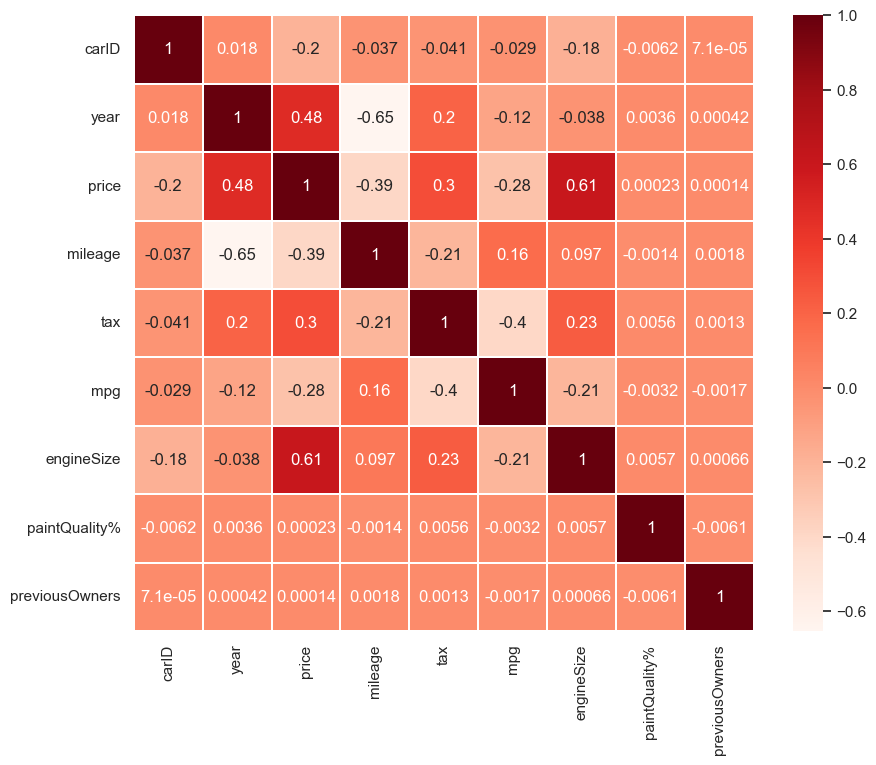

In [ ]:
# Remove rows with missing values
temp = train_db.dropna()

# Select numerical columns for correlation analysis
corr_data = temp.select_dtypes(include=["number"])

# Compute the Pearson correlation matrix
correlation_matrix = corr_data.corr(method="pearson")

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap = plt.cm.Reds, linewidths=0.1)
plt.show()

- year and mileage have a strong relationship
- and so does tax and pmg
- both paintQuality% and previousOwners seem to have little correlation with every variable

In [ ]:
one_hot = pd.get_dummies(train_db["Brand"], drop_first=True).astype(int)

train_db = pd.concat([train_db, one_hot], axis=1)

train_db['transmission'] = train_db['transmission'].replace('other', 'unknown')

one_hot2 = pd.get_dummies(train_db["transmission"], drop_first=True).astype(int)

train_db = pd.concat([train_db, one_hot2], axis=1)

train_db["fuelType"] = train_db["fuelType"].replace('other', 'electric')

one_hot3 = pd.get_dummies(train_db["fuelType"], drop_first=True).astype(int)

train_db = pd.concat([train_db, one_hot3], axis=1)

train_db = f.kfold_target_encode(train_db, cat_cols=['Brand','model'], target_col='price', n_splits=5)

In [ ]:
X = train_db.drop(columns=["price","carID"])
y = train_db["price"]
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.3, 
                                                  random_state = 0, 
                                                  shuffle = True)

In [ ]:
X_train_cat = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)

X_train_num = X_train.select_dtypes(include=np.number).set_index(X_train.index)

# repeat for val

X_val_cat = X_val.select_dtypes(exclude=np.number).set_index(X_val.index)

X_val_num = X_val.select_dtypes(include=np.number).set_index(X_val.index)


In [ ]:
scaler = MinMaxScaler()

#fit to training data
scaler.fit(X_train_num)

#transform the data
X_train_num_scaled = scaler.transform(X_train_num) # this will return an array

# Convert the array to a pandas dataframe
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train_num.columns).set_index(X_train.index)

X_val_num_scaled = scaler.transform(X_val_num)
X_val_num_scaled = pd.DataFrame(X_val_num_scaled, columns = X_val_num.columns).set_index(X_val.index)


#show results
X_train_num_scaled

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,bmw,ford,hyundai,...,skoda,toyota,vw,manual,semi-auto,unknown,electric,hybrid,petrol,Brand_model_encoded
9755,0.833333,0.253694,0.322009,0.194282,0.328358,0.446774,0.750,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.273483
7670,0.907407,0.159403,0.351810,0.177557,0.164179,0.430645,0.625,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.160889
27365,0.870370,0.179484,0.351810,0.173084,0.238806,0.503226,0.500,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.124938
46630,0.925926,0.161295,0.351810,0.149747,0.462687,0.753226,0.750,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.271596
7887,0.907407,0.181495,0.351810,0.184364,0.223881,0.591935,0.250,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.078819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21245,0.870370,0.183523,0.180450,0.206534,0.313433,0.591935,0.500,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.098932
45900,0.888889,0.215811,0.351810,0.180863,0.313433,0.430645,0.625,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.140887
42619,0.870370,0.214196,0.351810,0.212174,0.253731,0.470968,0.750,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.087135
43574,0.870370,0.275482,0.180450,0.215286,0.313433,0.608065,0.250,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.161609


In [55]:
for var in X_train_cat:
    f.TestCorrelationRatio(X_train_cat[var],y_train, var)

Brand is IMPORTANT for prediction (η = 0.537)
model is IMPORTANT for prediction (η = 0.761)
transmission is IMPORTANT for prediction (η = 0.542)
fuelType is IMPORTANT for prediction (η = 0.205)


In [56]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

reg = LassoCV()


reg.fit(X_train_num_scaled, y_train)

coef = pd.Series(reg.coef_, index = X_train_num_scaled.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


Lasso picked 22 variables and eliminated the other 0 variables


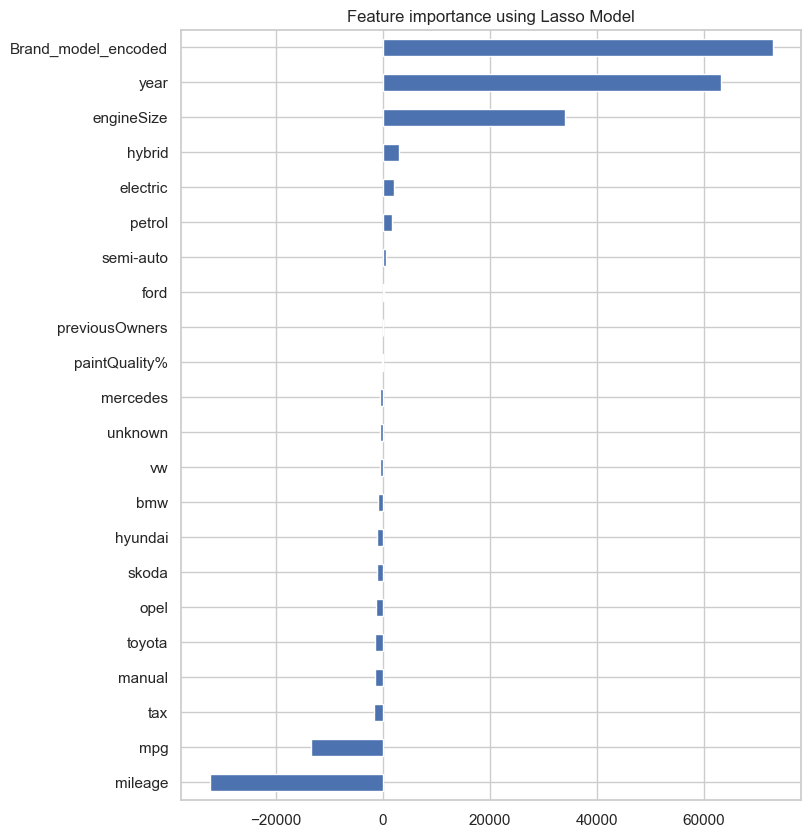

In [57]:
plot_importance(coef,'Lasso')

<hr>

### Numerical Data

| Predictor | Pearson | Lasso | What to do? (One possible way to "solve") |
| --- | --- | --- | --- |
| year | Keep? | Keep | Include in the model |
| engineSize | Keep |Keep| Include in the model |
| tax | Keep? | Discard | Try with and without |
| previousOwners | Keep? | Discard | Discard |
| mpg | Keep?  | Keep? | Try with and without |
| mileage | Keep | Keep | Keep |

<hr>


### Categorical Data

| Predictor | Correlation Ratio | 
| --- | --- | 
| Brand | Keep |  
|  model | Keep | 
| transmission | Keep |
| fuelType| Keep? |


<hr>




Even though we are using a random forest here, we still applied the same feature selection methods as in linear regression, and it ended up performing better than using all the features

In [ ]:
X_train_num = X_train_num.drop(columns=['previousOwners'])

X_val_num = X_val_num.drop(columns=['previousOwners'])

In [22]:
import pandas as pd
import numpy as np
import functionsML as f
from sklearn.model_selection import train_test_split, PredefinedSplit, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

# Função de Limpeza Básica (Sem Leakage)
def clean_data(df):
    df = df.copy()
    
    # Drop irrelevant
    df = df.drop(columns=["hasDamage","paintQuality%"], errors='ignore')
    
    # Text handling
    text_cols = df.select_dtypes(include=["object"]).columns
    df[text_cols] = df[text_cols].apply(lambda x: x.str.lower() if x.dtype=="object" else x)
    for col in df.select_dtypes(include="object").columns:
        df = f.fix_typos(col, df)

    # Filtering / Cleaning Rules
    df.loc[df["mileage"] < 0, "mileage"] = np.nan
    df.loc[~df["tax"].between(0, 600), "tax"] = np.nan
    df.loc[~df["mpg"].between(0, 150), "mpg"] = np.nan
    df.loc[~df["engineSize"].between(1, 6.3), "engineSize"] = np.nan
    df.loc[~df["year"].between(1990, 2020), "year"] = np.nan
    df.loc[~df["previousOwners"].between(0, 6), "previousOwners"] = np.nan # Opcional conforme o teu código

    # Numeric Transformations
    df['mileage'] = np.log1p(df['mileage'])
    df['mpg'] = np.log1p(df['mpg'])
    df['tax'] = np.log1p(df['tax'])
    
    # Types and Rounding
    df["year"] = df["year"].round()
    df["previousOwners"] = pd.to_numeric(df["previousOwners"], errors='coerce').round().astype("Int64")
    df["year"] = pd.to_numeric(df["year"], errors='coerce').round().astype("Int64")
    
    # Imputation
    df = f.fill_NaN_with_categorical(df, "Brand", ["model","transmission","fuelType"])
    df = f.fill_NaN_with_categorical(df, "Brand", ["model","transmission"])
    df = f.fill_NaN_with_categorical(df, "model", ["Brand","transmission","fuelType"])
    df = f.fill_NaN_with_categorical(df, "model", ["Brand","transmission"])
    df = f.fill_NaN_with_categorical(df, "mpg", ["model","fuelType"])
    
    df["transmission"] = df["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
    df["fuelType"] = df["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

    df = f.fill_NaN_with_mixed(df, "year", "model", "mileage")
    df = f.fill_NaN_with_mixed(df, "mileage", "model", "year")
    df = f.fill_NaN_with_mixed(df, "tax", "model", "year")
    df = f.fill_NaN_with_mixed(df, "engineSize", "model", "tax")

    df["previousOwners"] = df["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64")
    
    # Residual Fill
    numeric_cols = df.select_dtypes(include=["number"]).columns.drop(["carID", "price"], errors='ignore')
    for col in numeric_cols:
        df[col] = df[col].astype(float)
        global_mean = df[col].median()
        df[col] = df[col].fillna(global_mean)
        if "Int64" in str(df[col].dtype):
            df[col] = df[col].round().astype("Int64")
            
    return df

In [ ]:
# 1. Carregar Dados
train_db = pd.read_csv("./train.csv")
# Importante: Aplicar log no target logo no início se for essa a estratégia
train_db['price'] = np.log1p(train_db['price'])

# 2. HOLDOUT SPLIT (Separação Inicial)
# Aqui garantimos que a validação nunca vê o treino
train_set, val_set = train_test_split(train_db, test_size=0.3, random_state=42, shuffle=True)

# 3. Limpeza Independente (Clean Data)
train_set = clean_data(train_set)
val_set = clean_data(val_set)

# 4. ENCODING & SCALING (Onde ocorre o Data Leakage se não tiver cuidado)

# A. One-Hot Encoding
# Temos de garantir colunas iguais. Concatenamos só para gerar as dummies e separamos de novo.
train_len = len(train_set)
combined_temp = pd.concat([train_set, val_set], axis=0)

combined_temp = pd.get_dummies(combined_temp, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# Separar de volta
train_set_encoded = combined_temp.iloc[:train_len].copy()
val_set_encoded = combined_temp.iloc[train_len:].copy()

# B. Target Encoding (FIT no Treino, TRANSFORM no Treino e Validação)
# Calcular médias no Treino
mapping = train_set.groupby(["Brand", "model"])["price"].mean().to_dict()
global_mean = train_set["price"].mean()

# Aplicar ao Treino
train_set_encoded["Brand_model_encoded"] = train_set.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# Aplicar à Validação (usando o mapping do treino!)
val_set_encoded["Brand_model_encoded"] = val_set.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# 5. PREPARAÇÃO FINAL (X e y)
drop_cols = ["price", "carID", "model", "previousOwners"] # Colunas a remover

X_train = train_set_encoded.drop(columns=drop_cols, errors='ignore')
y_train = train_set_encoded["price"]

X_val = val_set_encoded.drop(columns=drop_cols, errors='ignore')
y_val = val_set_encoded["price"]

# C. Scaling (FIT no Treino, TRANSFORM em ambos)
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)

c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group_cat, target_col)
c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group

In [ ]:
# 1. Juntar os dados processados (Reset index para garantir alinhamento)
X_combined = pd.concat([X_train_scaled, X_val_scaled], axis=0).reset_index(drop=True)
y_combined = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

# 2. Criar a "Máscara" de Split (test_fold)
# -1 indica: "Este dado é de treino, usa para aprender"
#  0 indica: "Este dado é de validação, usa para testar" (0 é o índice do fold de validação)

# Array com -1 para o tamanho do treino
split_index_train = [-1] * len(X_train_scaled)
# Array com 0 para o tamanho da validação
split_index_val = [0] * len(X_val_scaled)

# Juntar os dois
test_fold = split_index_train + split_index_val

# 3. Criar o Objeto PredefinedSplit
ps = PredefinedSplit(test_fold)

# 4. Configurar o RandomizedSearchCV com cv=ps
# Exemplo com Random Forest
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10)
}

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=50,    # Número de tentativas
    cv=ps,        # <--- AQUI ESTÁ O TRUQUE: Usamos o nosso split personalizado
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 5. Executar a Busca
print("A iniciar Random Search com Predefined Split...")
# Passamos o X_combined e y_combined. Ele vai saber separar internamente graças ao 'ps'.
random_search.fit(X_combined, y_combined)

# 6. Resultados
print(f"Melhores Parâmetros: {random_search.best_params_}")
print(f"Melhor RMSE (log): {-random_search.best_score_:.4f}")

# O melhor modelo já fica treinado com TUDO (Treino + Validação) se refit=True (default)
best_model = random_search.best_estimator_

A iniciar Random Search com Predefined Split...
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Melhores Parâmetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 267}
Melhor RMSE (log): 0.1161


In [22]:
# 1. Carregar Teste
test_db = pd.read_csv("./test.csv")

# 2. Aplicar a mesma Limpeza (Função que criámos antes)
# Nota: Garante que definiste a função 'clean_data' no bloco anterior
test_db = clean_data(test_db) 

# 3. ENCODING (Cuidado Máximo aqui!)

# A. One-Hot Encoding
# O get_dummies no teste pode gerar colunas diferentes. Vamos resolver isso no passo de alinhamento.
test_db_encoded = pd.get_dummies(test_db, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# B. Target Encoding
# IMPORTANTE: Usar o 'mapping' e 'global_mean' que calculaste no TREINO (não recalcules no teste!)
if 'mapping' not in locals() or 'global_mean' not in locals():
    raise ValueError("Erro: As variáveis 'mapping' e 'global_mean' do treino não estão na memória.")

test_db_encoded["Brand_model_encoded"] = test_db.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# 4. PREPARAÇÃO FINAL
# Remover as mesmas colunas que removemos no treino
drop_cols = ["price", "carID", "model", "previousOwners"]
X_test = test_db_encoded.drop(columns=drop_cols, errors='ignore')

# 5. ALINHAMENTO DE COLUNAS (A "Vacina" contra erros)
# O modelo foi treinado com X_combined. O X_test tem de ter exatamente as mesmas colunas.
# Se faltar alguma (ex: Ferrari), preenchemos com 0. Se houver a mais, ignoramos.
cols_treino = X_combined.columns # Colunas usadas no fit do RandomizedSearch
X_test = X_test.reindex(columns=cols_treino, fill_value=0)

# 6. SCALING
# Usar o 'scaler' já treinado (não fazer fit!)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# 7. PREVISÃO
# Usar o best_model (que já está treinado com tudo)
print("A fazer previsões finais...")
y_test_pred_log = best_model.predict(X_test_scaled)

# 8. INVERTER O LOG (Trazer de volta para Euros)
y_test_pred_real = np.expm1(y_test_pred_log)

# 9. GUARDAR SUBMISSÃO
submission = pd.DataFrame({
    "carID": test_db["carID"], # Buscar o ID original
    "price": y_test_pred_real
})

submission.to_csv("submission_final_campeao.csv", index=False)
print("Sucesso! Ficheiro 'submission_final_campeao.csv' criado.")

A fazer previsões finais...
Sucesso! Ficheiro 'submission_final_campeao.csv' criado.


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# --- CONFIGURAÇÃO PARA KNN ---
# 1. Juntar os dados processados (Reset index para garantir alinhamento)
X_combined = pd.concat([X_train_scaled, X_val_scaled], axis=0).reset_index(drop=True)
y_combined = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

# 2. Criar a "Máscara" de Split (test_fold)
# -1 indica: "Este dado é de treino, usa para aprender"
#  0 indica: "Este dado é de validação, usa para testar" (0 é o índice do fold de validação)

# Array com -1 para o tamanho do treino
split_index_train = [-1] * len(X_train_scaled)
# Array com 0 para o tamanho da validação
split_index_val = [0] * len(X_val_scaled)

# Juntar os dois
test_fold = split_index_train + split_index_val

# 3. Criar o Objeto PredefinedSplit
ps = PredefinedSplit(test_fold)

# 1. Definir o Modelo Base
knn_model = KNeighborsRegressor(n_jobs=-1)

# 2. Definir a Grelha de Hiperparâmetros
param_dist_knn = {
    # n_neighbors: 'K'. Valores baixos (3) ajustam muito, altos (50) generalizam.
    'n_neighbors': randint(3, 50),
    
    # weights: 
    # 'uniform' = todos os vizinhos valem o mesmo.
    # 'distance' = vizinhos mais próximos têm mais peso (geralmente melhor para preços)
    'weights': ['uniform', 'distance'],
    
    # metric: Como medir a distância entre os carros
    # 'manhattan' (L1) costuma funcionar bem com muitas colunas (high-dim)
    # 'euclidean' (L2) é o padrão geométrico
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    
    # p: Só é usado se metric='minkowski' (1=Manhattan, 2=Euclidean)
    'p': [1, 2]
}

# 3. Configurar RandomizedSearchCV (Usando o MESMO 'ps' e 'X_combined')
random_search_knn = RandomizedSearchCV(
    estimator=knn_model,
    param_distributions=param_dist_knn,
    n_iter=30,     # KNN é muito rápido, podemos testar 30 combinações
    cv=ps,         # Reutilizamos o PredefinedSplit criado no passo anterior
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 4. Executar a Busca
print("A iniciar Random Search para KNN com Predefined Split...")
# IMPORTANTE: X_combined já está escalado (MinMaxScaler), o que é obrigatório para KNN!
random_search_knn.fit(X_combined, y_combined)

# 5. Resultados
print(f"Melhores Parâmetros KNN: {random_search_knn.best_params_}")
print(f"Melhor RMSE KNN (log): {-random_search_knn.best_score_:.4f}")

# O melhor modelo KNN já fica treinado com TUDO
best_knn = random_search_knn.best_estimator_

A iniciar Random Search para KNN com Predefined Split...
Fitting 1 folds for each of 30 candidates, totalling 30 fits
Melhores Parâmetros KNN: {'metric': 'minkowski', 'n_neighbors': 24, 'p': 1, 'weights': 'distance'}
Melhor RMSE KNN (log): 0.1997


In [ ]:
# --- GERAR SUBMISSÃO PARA O KNN ---

# 1. Carregar Teste
test_db = pd.read_csv("./test.csv")

# 2. Limpeza (Usando a tua função clean_data)
test_clean = clean_data(test_db)

# 3. One-Hot Encoding (Alinhado)
test_encoded = pd.get_dummies(test_clean, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# 4. Target Encoding (Usar o 'mapping' do Treino!)
test_encoded["Brand_model_encoded"] = test_clean.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# 5. Preparação Final (Remover colunas e Alinhar)
drop_cols = ["price", "carID", "model", "previousOwners"]
X_test_knn = test_encoded.drop(columns=drop_cols, errors='ignore')

# ALINHAMENTO DE COLUNAS (Fundamental)
# Garante que o teste tem as mesmas colunas que o X_combined
cols_treino = X_combined.columns 
X_test_knn = X_test_knn.reindex(columns=cols_treino, fill_value=0)

# 6. SCALING (Usar o scaler do treino)
X_test_knn_scaled = pd.DataFrame(scaler.transform(X_test_knn), columns=X_test_knn.columns, index=X_test_knn.index)

# 7. Previsão e Inversão do Log
y_pred_knn_log = best_knn.predict(X_test_knn_scaled)
y_pred_knn_real = np.expm1(y_pred_knn_log)

# 8. Guardar
submission_knn = pd.DataFrame({
    "carID": test_db["carID"],
    "price": y_pred_knn_real
})
submission_knn.to_csv("submission_knn.csv", index=False)
print("Submissão KNN criada!")

c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group_cat, target_col)
c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Brand_bmw
- Brand_ford
- Brand_hyundai
- Brand_mercedes
- Brand_model_encoded
- ...


a usar brand_enconded, no entanto o stor disse para n usar as catgs

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, PredefinedSplit, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import randint

# ... (A tua função clean_data deve estar definida acima) ...

# 1. Carregar e Limpar
train_db = pd.read_csv("./train.csv")
train_db['price'] = np.log1p(train_db['price'])

# Split (Holdout)
train_set, val_set = train_test_split(train_db, test_size=0.3, random_state=42, shuffle=True)

# Limpeza
train_set = clean_data(train_set)
val_set = clean_data(val_set)

# --- 2. TARGET ENCODING (A "Arma Secreta") ---
# Calculamos a média de preço por Marca/Modelo APENAS no Treino
mapping = train_set.groupby(["Brand", "model"])["price"].mean().to_dict()
global_mean = train_set["price"].mean()

# Criamos a coluna no Treino
train_set["Brand_model_encoded"] = train_set.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# Criamos a coluna na Validação (usando o conhecimento do Treino)
val_set["Brand_model_encoded"] = val_set.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# --- 3. SELEÇÃO DE FEATURES ---
# Agora selecionamos as 5 numéricas + a nova encoded
cols_to_use = [
    'year', 
    'mileage', 
    'tax', 
    'mpg', 
    'engineSize', 
    'Brand_model_encoded' # <-- Ela entra aqui!
]

X_train = train_set[cols_to_use]
y_train = train_set["price"]

X_val = val_set[cols_to_use]
y_val = val_set["price"]

# --- 4. SCALING ---
# O KNN precisa disto
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)

# --- 5. JUNTAR PARA O RANDOM SEARCH (PredefinedSplit) ---
X_combined = pd.concat([X_train_scaled, X_val_scaled], axis=0).reset_index(drop=True)
y_combined = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

# Criar a máscara de split (-1 = Treino, 0 = Validação)
split_index = [-1] * len(X_train_scaled) + [0] * len(X_val_scaled)
ps = PredefinedSplit(split_index)

# --- 6. CONFIGURAR E TREINAR O KNN ---
knn_model = KNeighborsRegressor(n_jobs=-1)

param_dist_knn = {
    'n_neighbors': randint(3, 50),
    'weights': ['uniform', 'distance'], # 'distance' costuma ser o melhor
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]
}

random_search_knn = RandomizedSearchCV(
    estimator=knn_model,
    param_distributions=param_dist_knn,
    n_iter=30,
    cv=ps,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print(f"A treinar KNN com {len(cols_to_use)} colunas: {cols_to_use}")
random_search_knn.fit(X_combined, y_combined)

print(f"Melhores Parâmetros: {random_search_knn.best_params_}")
print(f"Melhor RMSE (log): {-random_search_knn.best_score_:.4f}")

best_knn_encoded = random_search_knn.best_estimator_

c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group_cat, target_col)
c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group

A treinar KNN com 6 colunas: ['year', 'mileage', 'tax', 'mpg', 'engineSize', 'Brand_model_encoded']
Fitting 1 folds for each of 30 candidates, totalling 30 fits
Melhores Parâmetros: {'metric': 'manhattan', 'n_neighbors': 8, 'p': 2, 'weights': 'distance'}
Melhor RMSE (log): 0.1306


In [28]:
# --- SUBMISSÃO KNN (Numéricas + Target Encoded) ---

# 1. Carregar e Limpar
test_db = pd.read_csv("./test.csv")
test_clean = clean_data(test_db)

# 2. Criar a coluna Brand_model_encoded (Usando mapping do TREINO)
if 'mapping' in locals():
    test_clean["Brand_model_encoded"] = test_clean.apply(
        lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
    )
else:
    raise ValueError("Atenção: O dicionário 'mapping' não foi encontrado. Corre o treino primeiro!")

# 3. Selecionar APENAS as 6 colunas
X_test_knn = test_clean[cols_to_use]

# 4. Scaling
# Usar o scaler que já conhece estas 6 colunas
X_test_knn_scaled = pd.DataFrame(scaler.transform(X_test_knn), columns=X_test_knn.columns, index=X_test_knn.index)

# 5. Previsão
print("A prever...")
y_pred_knn_log = best_knn_encoded.predict(X_test_knn_scaled)
y_pred_knn_real = np.expm1(y_pred_knn_log)

# 6. Guardar
submission_knn = pd.DataFrame({
    "carID": test_db["carID"],
    "price": y_pred_knn_real
})
submission_knn.to_csv("submission_knn_encoded.csv", index=False)
print("Submissão 'submission_knn_encoded.csv' criada com sucesso!")

c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group_cat, target_col)
c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group

A prever...
Submissão 'submission_knn_encoded.csv' criada com sucesso!


In [ ]:
from sklearn.neural_network import MLPRegressor

# --- CONFIGURAÇÃO PARA REDE NEURAL (MLP) ---
# 1. Juntar os dados processados (Reset index para garantir alinhamento)
X_combined = pd.concat([X_train_scaled, X_val_scaled], axis=0).reset_index(drop=True)
y_combined = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

# 2. Criar a "Máscara" de Split (test_fold)
# -1 indica: "Este dado é de treino, usa para aprender"
#  0 indica: "Este dado é de validação, usa para testar" (0 é o índice do fold de validação)

# Array com -1 para o tamanho do treino
split_index_train = [-1] * len(X_train_scaled)
# Array com 0 para o tamanho da validação
split_index_val = [0] * len(X_val_scaled)

# Juntar os dois
test_fold = split_index_train + split_index_val

# 3. Criar o Objeto PredefinedSplit
ps = PredefinedSplit(test_fold)



# 1. Definir o Modelo Base
# max_iter=1000 dá tempo à rede para aprender sem parar cedo demais
# early_stopping=True ajuda a parar se não estiver a aprender (poupa tempo)
nn_model = MLPRegressor(max_iter=1000, early_stopping=True, random_state=42)

# 2. Definir a Grelha de Hiperparâmetros
param_dist = {
    # Arquitetura: Testamos desde redes simples até muito profundas/largas
    'hidden_layer_sizes': [
        (50,), (100,), (100, 50), (200, 100), 
        (100, 50, 25), (200, 100, 50)  ###incluir sempre os defaults
    ],
    
    # Ativação: A Tanh por vezes lida melhor com regressão do que a ReLU
    'activation': ['relu', 'tanh', 'logistic'],
    
    # Solver: O SGD é clássico, Adam é moderno, LBFGS é bom para dados pequenos
    'solver': ['adam', 'sgd', 'lbfgs'],
    
    # alpha: Regularização L2 (para evitar overfitting)
    # Valores pequenos (0.0001) a moderados (0.05)
    'alpha': [0.0001, 0.001, 0.01, 0.05],
    
    'batch_size': [32, 64, 'auto'],
    # Learning Rate: Importante para o SGD
    'learning_rate': ['constant', 'adaptive', 'invscaling'],
    
    
    # Early Stopping: Ativar para evitar overfitting
    'early_stopping': [True],
    #como tenho early stopping 
    # Validation Fraction: Quanto dos dados de treino usar para parar cedo (se early_stopping=True)
    'validation_fraction': [0.1, 0.2]
}

param_dist_nn = {
    # hidden_layer_sizes: Define a "arquitetura" da rede (neurónios por camada)
    # (50,) -> 1 camada com 50 neurónios
    # (100, 50) -> 2 camadas (100 na primeira, 50 na segunda)
    # (100, 50, 25) -> 3 camadas (Rede profunda)
    'hidden_layer_sizes': [
        (50,), (100,), 
        (50, 25), (100, 50), (200, 100),
        (100, 50, 25)
    ],
    
    # activation: A "fórmula" que cada neurónio usa
    # 'relu' é o padrão moderno, 'tanh' às vezes funciona bem para regressão
    'activation': ['relu', 'tanh'],
    
    # solver: O algoritmo que ajusta os pesos
    # 'adam' funciona bem quase sempre, 'sgd' pode ser melhor mas requer ajuste fino
    'solver': ['adam'],
    
    # alpha: Regularização L2 (para evitar overfitting)
    # Valores pequenos (0.0001) a moderados (0.05)
    'alpha': [0.0001, 0.001, 0.01, 0.05],
    
    # learning_rate_init: A velocidade de aprendizagem inicial
    'learning_rate_init': [0.001, 0.01]
}

# 3. Randomized Search
random_search_nn = RandomizedSearchCV(
    estimator=nn_model,
    param_distributions=param_dist,
    n_iter=50,     # Testar 50 arquiteturas diferentes
    cv=ps,         # O TEU SPLIT PERSONALIZADO
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 4. Executar a Busca
print("A iniciar Random Search para Rede Neural...")
# IMPORTANTE: X_combined tem de estar ESCALADO!
random_search_nn.fit(X_combined, y_combined)

# 5. Resultados
print(f"Melhores Parâmetros NN: {random_search_nn.best_params_}")
print(f"Melhor RMSE NN (log): {-random_search_nn.best_score_:.4f}")

# Guardar o campeão
best_nn = random_search_nn.best_estimator_

A iniciar Random Search para Rede Neural...
Fitting 1 folds for each of 50 candidates, totalling 50 fits


KeyboardInterrupt: 

In [ ]:
# --- GERAR SUBMISSÃO PARA A REDE NEURAL ---

# 1. Carregar Teste
test_db = pd.read_csv("./test.csv")

# 3. Encoding
test_encoded = pd.get_dummies(test_clean, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# Target Encode
test_encoded["Brand_model_encoded"] = test_clean.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# 4. Alinhamento de Colunas (Obrigatório)
drop_cols = ["price", "carID", "model", "previousOwners"]
X_test_nn = test_encoded.drop(columns=drop_cols, errors='ignore')

# Garante que o teste tem as mesmas colunas que o treino
cols_treino = X_combined.columns 
X_test_nn = X_test_nn.reindex(columns=cols_treino, fill_value=0)

# 5. SCALING (Obrigatório: Usar o scaler do treino)
X_test_nn_scaled = pd.DataFrame(scaler.transform(X_test_nn), columns=X_test_nn.columns, index=X_test_nn.index)

# 6. Previsão
print("A prever com a Rede Neural...")
y_pred_nn_log = best_nn.predict(X_test_nn_scaled)

# Inverter Log
y_pred_nn_real = np.expm1(y_pred_nn_log)

# 7. Guardar
submission_nn = pd.DataFrame({
    "carID": test_db["carID"],
    "price": y_pred_nn_real
})
submission_nn.to_csv("submission_nn.csv", index=False)
print("Submissão Neural Network criada!")

A prever com a Rede Neural...
Submissão Neural Network criada!


Dimensões Treino: (53181, 22)
Dimensões Validação: (22792, 22)

A iniciar treino da Rede Neuronal...
Epoch 1/150
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3.9216 - mae: 1.2653 - val_loss: 0.2032 - val_mae: 0.3344
Epoch 2/150
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7351 - mae: 0.6606 - val_loss: 0.1727 - val_mae: 0.3581
Epoch 3/150
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1956 - mae: 0.3346 - val_loss: 0.0622 - val_mae: 0.1771
Epoch 4/150
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0670 - mae: 0.1846 - val_loss: 0.0289 - val_mae: 0.1223
Epoch 5/150
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0432 - mae: 0.1536 - val_loss: 0.0285 - val_mae: 0.1234
Epoch 6/150
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0380 - mae: 0.1430 - val_loss: 0.0323 - val_mae: 0.1285
Epoch 7/150
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0348 - mae: 0.1356 - val_loss: 0.0301 - val_mae: 0.1241
Epoch 8/150
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

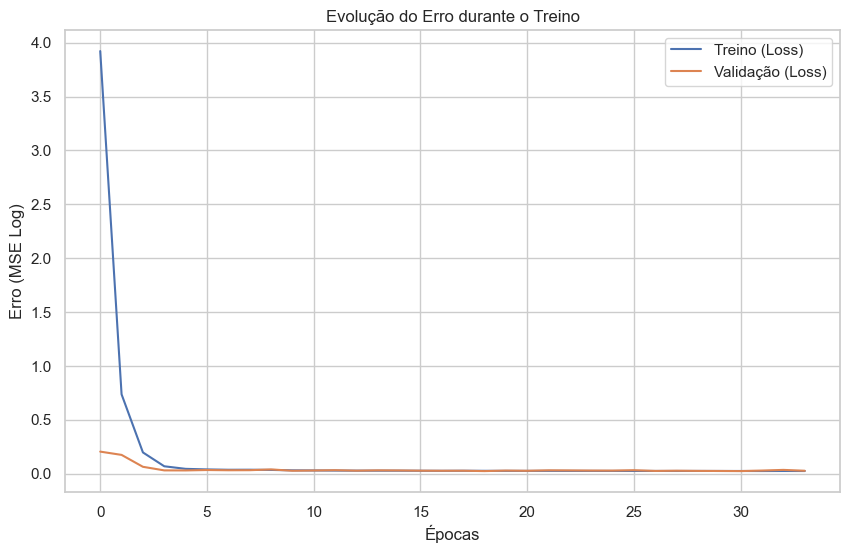

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# --- 1. PREPARAR DADOS (Separar usando o teu PredefinedSplit) ---
# O 'ps.test_fold' tem -1 para treino e 0 para validação.
# Vamos usar isso para filtrar o X_combined.

# Converter para numpy array para indexação booleana funcionar bem
indices = np.array(ps.test_fold)

# Separar de volta (Treino vs Validação)
X_train_nn = X_combined[indices == -1]
y_train_nn = y_combined[indices == -1]

X_val_nn = X_combined[indices == 0]
y_val_nn = y_combined[indices == 0]

print(f"Dimensões Treino: {X_train_nn.shape}")
print(f"Dimensões Validação: {X_val_nn.shape}")

# --- 2. DEFINIR ARQUITETURA ---
input_shape = [X_train_nn.shape[1]] # Número de colunas

model = keras.Sequential([
    # Camada 1: Entrada -> 128 neurónios
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3), # Desliga 30% para evitar decorar
    
    # Camada 2: 64 neurónios
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    
    # Camada 3: 32 neurónios
    layers.Dense(32, activation='relu'),
    
    # Saída: 1 valor (Preço)
    layers.Dense(1)
])

# --- 3. COMPILAR ---
model.compile(
    optimizer='adam',
    loss='mean_squared_error', # Otimiza o MSE
    metrics=['mae'] # Monitoriza o MAE
)

# --- 4. CONFIGURAR PARAGEM (Early Stopping) ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0005, # Precisa de melhorar pelo menos isto
    patience=15,      # Espera 15 épocas sem melhoria antes de parar
    restore_best_weights=True # Volta atrás para o melhor momento
)

# --- 5. TREINAR ---
print("\nA iniciar treino da Rede Neuronal...")
history = model.fit(
    X_train_nn, y_train_nn,
    validation_data=(X_val_nn, y_val_nn),
    batch_size=32, # Processa 32 carros de cada vez
    epochs=150,    # Máximo de tentativas
    callbacks=[early_stopping],
    verbose=1
)

# --- 6. AVALIAR ---
# Fazer previsões na validação
y_pred_nn_log = model.predict(X_val_nn)

# Importante: Como y_train/y_val estão em LOG, as métricas aqui são em LOG.
print("\n--- Performance (Escala Logarítmica) ---")
print(f"R²: {r2_score(y_val_nn, y_pred_nn_log):.3f}")
print(f"RMSE (Log): {np.sqrt(mean_squared_error(y_val_nn, y_pred_nn_log)):.4f}")

# Converter para Euros para ter noção real
y_val_real = np.expm1(y_val_nn)
y_pred_real = np.expm1(y_pred_nn_log)

print("\n--- Performance (Euros Reais Estimados) ---")
print(f"RMSE (Euros): {np.sqrt(mean_squared_error(y_val_real, y_pred_real)):.2f}€")
print(f"MAE (Euros): {mean_absolute_error(y_val_real, y_pred_real):.2f}€")

# --- 7. GRÁFICO ---
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Treino (Loss)')
plt.plot(history.history['val_loss'], label='Validação (Loss)')
plt.title('Evolução do Erro durante o Treino')
plt.xlabel('Épocas')
plt.ylabel('Erro (MSE Log)')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# --- GERAR SUBMISSÃO COM A REDE NEURAL (KERAS) ---

import pandas as pd
import numpy as np

# 1. Carregar os dados de Teste (Novos dados)
test_db = pd.read_csv("./test.csv")

# 2. Limpeza (Usar a mesma função e limites do treino)

test_clean = clean_data(test_db) 

# 3. Encoding (Transformar texto em números)

# A. One-Hot Encoding
test_encoded = pd.get_dummies(test_clean, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# B. Target Encoding 
# IMPORTANTE: Tens de usar o 'mapping' e 'global_mean' que aprendeste no TREINO.
# Não recalculas isto no teste!
if 'mapping' in locals():
    test_encoded["Brand_model_encoded"] = test_clean.apply(
        lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
    )
else:
    print("AVISO: 'mapping' não encontrado. O Target Encoding pode falhar.")

# 4. Preparação Final das Colunas
# Remover as colunas que não entram no modelo
drop_cols = ["price", "carID", "model", "previousOwners", "paintQuality%"] 
X_test_nn = test_encoded.drop(columns=drop_cols, errors='ignore')

# --- PASSO CRÍTICO: ALINHAMENTO ---
# A Rede Neuronal explode se o número de colunas for diferente do treino.
# Vamos forçar o X_test_nn a ter exatamente as colunas do X_train_nn (ou X_combined).

# Recuperar nomes das colunas usadas no treino
# (Dependendo de como chamaste a variável no passo anterior, pode ser X_combined ou X_train_num_scaled)
if 'X_combined' in locals():
    cols_treino = X_combined.columns
elif 'X_train_num_scaled' in locals():
    cols_treino = X_train_num_scaled.columns
else:
    raise ValueError("Não encontro os dados de treino para verificar as colunas!")

# Reindexar: Adiciona colunas em falta (com 0) e remove as que estão a mais
X_test_nn = X_test_nn.reindex(columns=cols_treino, fill_value=0)

# 5. SCALING (Obrigatório para NN)
# Usar o scaler (StandardScaler ou MinMax) que já foi 'fitado' no treino
X_test_nn_scaled = pd.DataFrame(scaler.transform(X_test_nn), columns=X_test_nn.columns, index=X_test_nn.index)

# 6. PREVISÃO
print("A fazer previsões com a Rede Neuronal...")
y_pred_log = model.predict(X_test_nn_scaled)

# O Keras devolve uma lista de listas [[10.1], [10.2]], usamos flatten para ficar [10.1, 10.2]
y_pred_log = y_pred_log.flatten()

# 7. INVERTER LOG (Trazer para Euros)
y_pred_real = np.expm1(y_pred_log)

# 8. GUARDAR FICHEIRO
submission_nn = pd.DataFrame({
    "carID": test_db["carID"],
    "price": y_pred_real
})

submission_nn.to_csv("submission_nn_keras.csv", index=False)
print("Sucesso! Ficheiro 'submission_nn_keras.csv' criado.")

A fazer previsões com a Rede Neuronal...
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step
Sucesso! Ficheiro 'submission_nn_keras.csv' criado.


The n_estimators was tested through trial and error

In [ ]:
# model = RandomForestRegressor(
#     n_estimators=70,   # number of trees
#     random_state=42,
#     n_jobs=-1           
# )
# model.fit(X_train_num, y_train)

# # 4. Predict
# y_pred = model.predict(X_val_num)

# # 5. Evaluate
# print(f"R²: {r2_score(y_val, y_pred):.3f}")
# print(f"MAE: {mean_absolute_error(y_val, y_pred):.2f}")
# print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_pred)):.2f}")


R²: 0.938
MAE: 1336.35
RMSE: 2350.33


Now we apply all the methods we analysed to the Random Forest model

In [ ]:
# # Drop irrelevant column
# test_db = test_db.drop(columns="hasDamage")

# # Lowercase text columns
# text_cols = test_db.select_dtypes(include=["object"]).columns
# test_db[text_cols] = test_db[text_cols].apply(lambda x: x.str.lower() if x.dtype=="object" else x)

# # Loop and fix all categorical columns (if your fix_typos function works for test set)
# for col in test_db.select_dtypes(include="object").columns:
#     test_db = f.fix_typos(col, test_db)

# # Apply the same filtering rules
# test_db.loc[test_db["mileage"] < 0, "mileage"] = np.nan
# test_db.loc[~test_db["tax"].between(0, 600), "tax"] = np.nan
# test_db.loc[~test_db["mpg"].between(0, 150), "mpg"] = np.nan
# test_db.loc[~test_db["engineSize"].between(1, 6.3), "engineSize"] = np.nan
# test_db.loc[test_db["paintQuality%"] > 100, "paintQuality%"] = np.nan
# test_db.loc[~test_db["year"].between(1990, 2020), "year"] = np.nan


# # Rounding future Int values
# test_db.loc[:, "year"] = test_db["year"].round()

# # Remove negative/irrational previousOwners
# #test_db.loc[(test_db['previousOwners'] < 0) | (test_db['previousOwners'] % 1 != 0),'previousOwners'] = np.nan

# # Round floats to 1 digit
# for col in test_db.select_dtypes(include="float64").columns:
#     test_db[col] = test_db[col].round(1)

# # Remove paintQuality% above 100
# #test_db.loc[test_db["paintQuality%"] > 100, "paintQuality%"] = np.nan

# # Remove negative values from numeric columns
# for col in test_db.select_dtypes(include="float64").columns:
#     test_db = f.negative_to_nan_columns(col, test_db)

# # Safely convert previousOwners and year to nullable integers
# test_db["previousOwners"] = pd.to_numeric(test_db["previousOwners"], errors='coerce').round().astype("Int64")
# test_db["year"] = pd.to_numeric(test_db["year"], errors='coerce').round().astype("Int64")

# # Fill categorical columns using the same functions as training
# test_db = f.fill_NaN_with_categorical(test_db, "Brand", ["model","transmission","fuelType"])
# test_db = f.fill_NaN_with_categorical(test_db, "Brand", ["model","transmission"])
# test_db = f.fill_NaN_with_categorical(test_db, "model", ["Brand","transmission","fuelType"])
# test_db = f.fill_NaN_with_categorical(test_db, "model", ["Brand","transmission"])
# test_db = f.fill_NaN_with_categorical(test_db, "mpg", ["model","fuelType"])
# test_db["transmission"] = test_db["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
# test_db["fuelType"] = test_db["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

# # Fill numeric columns with mixed helper approach
# test_db = f.fill_NaN_with_mixed(test_db, "year", "model", "mileage")
# test_db = f.fill_NaN_with_mixed(test_db, "mileage", "model", "year")
# test_db = f.fill_NaN_with_mixed(test_db, "tax", "model", "year")
# test_db = f.fill_NaN_with_mixed(test_db, "engineSize", "model", "tax")

# # Fill numeric columns with median
# test_db["paintQuality%"] = test_db["paintQuality%"].transform(lambda x: x.fillna(x.median()))
# test_db["previousOwners"] = test_db["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64")

# numeric_cols = test_db.select_dtypes(include=["number"]).columns.drop("carID", errors='ignore')

# for col in numeric_cols:
#     # Convert to float to safely handle NaNs and group means
#     test_db[col] = test_db[col].astype(float)
    
#     # Compute model mean
#     category_means = test_db.groupby("model")[col].transform('median')
    
#     # Fill NaNs with category mean
#     test_db[col] = test_db[col].fillna(category_means)
    
#     # Fill any remaining NaNs with global mean
#     global_mean = test_db[col].median()
#     test_db[col] = test_db[col].fillna(global_mean)
    
#     # Optional: convert back to integer if column was originally integer
#     if "Int64" in str(test_db[col].dtype):
#         test_db[col] = test_db[col].round().astype("Int64")



        
# # One-hot encode categorical columns
# brand_dummies = pd.get_dummies(test_db["Brand"], drop_first=True).astype(int)
# test_db = pd.concat([test_db, brand_dummies], axis=1)

# # Merge rare transmission values
# test_db['transmission'] = test_db['transmission'].replace('other', 'unknown')
# transmission_dummies = pd.get_dummies(test_db["transmission"], drop_first=True).astype(int)
# test_db = pd.concat([test_db, transmission_dummies], axis=1)

# # Merge rare fuelType values
# test_db["fuelType"] = test_db["fuelType"].replace('other', 'electric')
# fuel_dummies = pd.get_dummies(test_db["fuelType"], drop_first=True).astype(int)
# test_db = pd.concat([test_db, fuel_dummies], axis=1)


# # Create mapping dictionary from training data using both Brand and model
# mapping = (
#     train_db
#     .set_index(["Brand", "model"])["Brand_model_encoded"]
#     .to_dict()
# )

# # Compute global mean for unseen Brand-model pairs
# global_mean = train_db["Brand_model_encoded"].median()

# # Map test_df (Brand, model) pairs to encoded values
# test_db["Brand_model_encoded"] = (
#     test_db[["Brand", "model"]]
#     .apply(lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1)
# )

# # Prepare features (exclude price and ID if present)
# X_test = test_db.drop(columns=["carID"], errors='ignore')  # ignore if price not in test
# X_test_num = X_test.select_dtypes(include=np.number).set_index(X_test.index)

# X_test_num= X_test_num.drop(columns=[ 'previousOwners', "paintQuality%"])

In [ ]:

# y_test_pred = model.predict(X_test_num)

# # Add predictions to the test DataFrame
# #test_db['price'] = np.expm1(y_test_pred)
# test_db['price'] = (y_test_pred)

# # Create a new DataFrame with only carID and predicted price
# submission = test_db[['carID', 'price']].copy()

# # Save to CSV
# submission.to_csv("predicted_prices.csv", index=False)
